## Прогнозирование оттока и категоризация пользователей

### Содержание:

1. [Описание проекта](#intro)  
2. [Подготовка среды](#env)  
3. [Загрузка данных и первичный обзор](#load)  
4. [EDA](#eda)  
5. [Выбор модели и признаки](#model_selection)  
6. [Обучение лучшей модели](#best_model)  
7. [Кластеризация](#clusterization)  
8. [Выводы и рекомендации](#conclusions)

### 1. Описание проекта <a id='intro'> </a>

**Заказчик**: Фитнес-центр "Культурист-датасаентист"  
**Объект исследования**: Данные за месяц до оттока и факт оттока  
**Цели исследования**:  
1. Пргнозирование оттока клиентов  
2. Формирование типичного портрета клиента  
3. Анализ признаков влияющих на отток  

**Описание данных**:

* `Churn` — факт оттока в текущем месяце;  
  
Данные клиента за предыдущий до проверки факта оттока месяц:  
* `gender` — пол;  
* `Near_Location` — проживание или работа в районе, где находится фитнес-центр;  
* `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);  
* `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);  
* `Phone` — наличие контактного телефона;  
* `Age` — возраст;  
* `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах)  
  
Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:  
  
* `Contract_period` — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);  
* `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);  
* `Group_visits` — факт посещения групповых занятий;  
* `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;  
* `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;  
* `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.  

### 2. Подготовка среды <a id='env'> </a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import datetime as dt
import matplotlib.lines as mlines
import os
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', 120)

### 3. Загрузка данных и первичный обзор <a id='load'> </a>

Проверю существования пути и загружу данные в зависимости от результата

In [3]:
if os.path.exists('/datasets/') == True:
    gym_churn = pd.read_csv('/datasets/gym_churn.csv')
else:
    gym_churn = pd.read_csv('gym_churn.csv')

Посмотрю на первый пять строк

In [4]:
gym_churn.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


Узнаю размер датасета

In [5]:
gym_churn.shape

(4000, 14)

Четыре тысячи строк. Не густо, но вплоне достаточно для обучения модели. Ведь если воспользоваться формулой для подсчета минимальной выборки, то необходимо будет 1300 данных. В датасете их бьльше

Методом `info` посмотрю на структуру данных

In [6]:
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Все данные представлены в числовом формате и судя по всему пропусков нет.

Методом `describe` посмотрю на структуру числовых данных

In [7]:
gym_churn.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,"4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00"
mean,0.51,0.85,0.49,0.31,0.90,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.30,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.00,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.00,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.00,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.00,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


Пока визуально никаких аномалий и выбросов не видно. Проверю на дубликаты

In [8]:
gym_churn.duplicated().sum()

0

Дубликатов нет. Можно приступать к исследовательскому анализу

Напоследок приведу наименования колонок к нижнему регистру. Мне так легче работать

In [9]:
gym_churn = gym_churn.rename(
    columns={col : col.lower() for col in gym_churn.columns}
)

### 4. EDA <a id='eda'> </a>

Для начала посмотрю как распределяется целевая категория

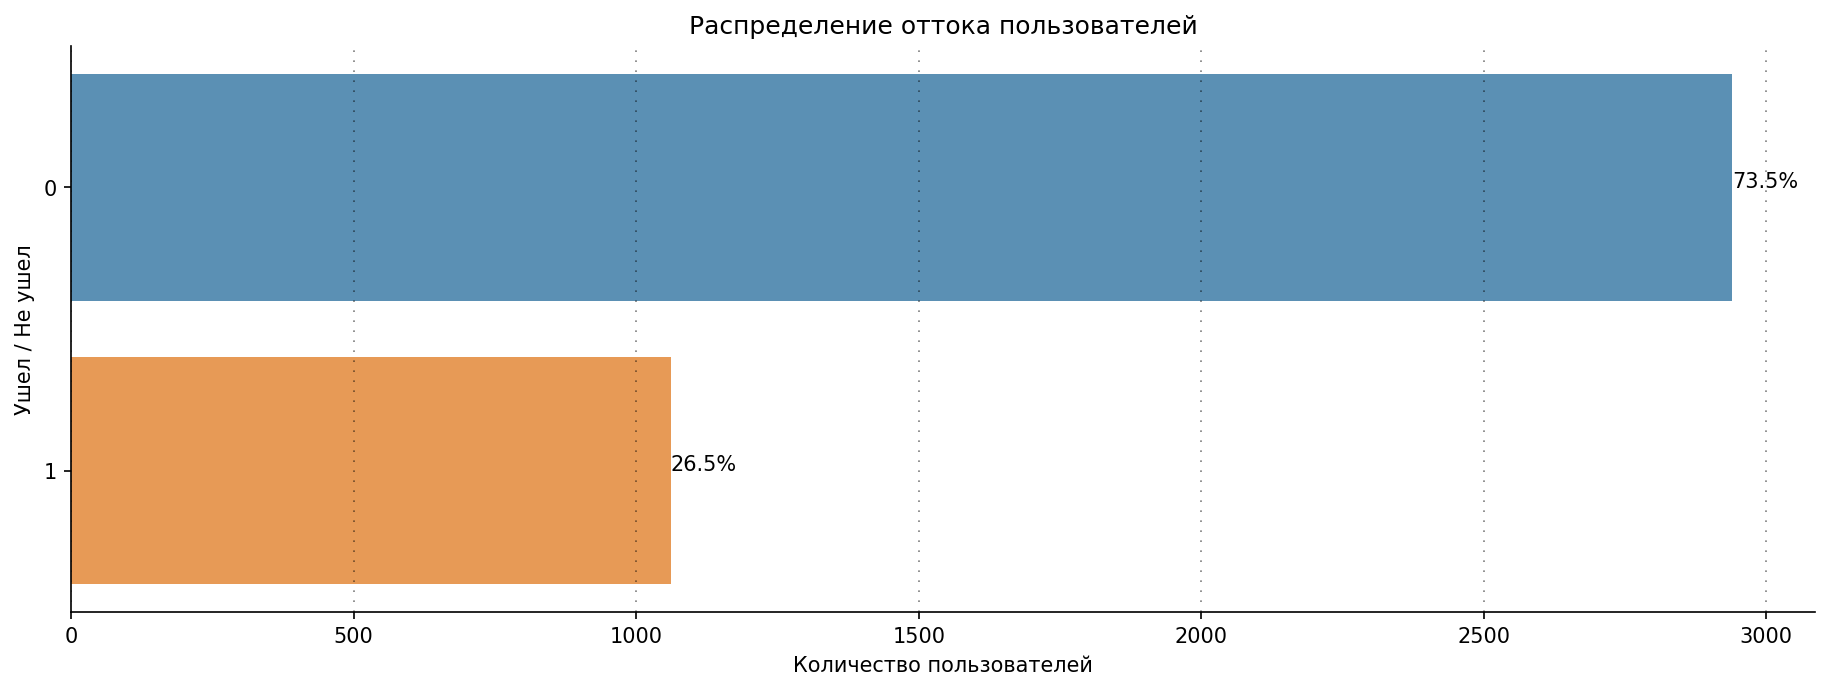

In [10]:
fig = plt.figure(figsize=(15, 5), dpi=150)
ax = sns.countplot(y='churn', data=gym_churn, alpha=0.8)
total = gym_churn.shape[0]
ax.grid(b=True, color='black', linestyle=':', axis='x', dashes=(1,5), alpha=0.5)
ax.set_title('Распределение оттока пользователей')

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y))

ax.set_xlabel('Количество пользователей')
ax.set_ylabel('Ушел / Не ушел')
sns.despine()
plt.show()

Как видно больше четверти пользователей ушли. Нужно узнать, что сподвигло их на это

Теперь посмотрю как распределяются другие булевые метрики. Есть ли дисбаланс

In [11]:
bool_cols = ('gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits')

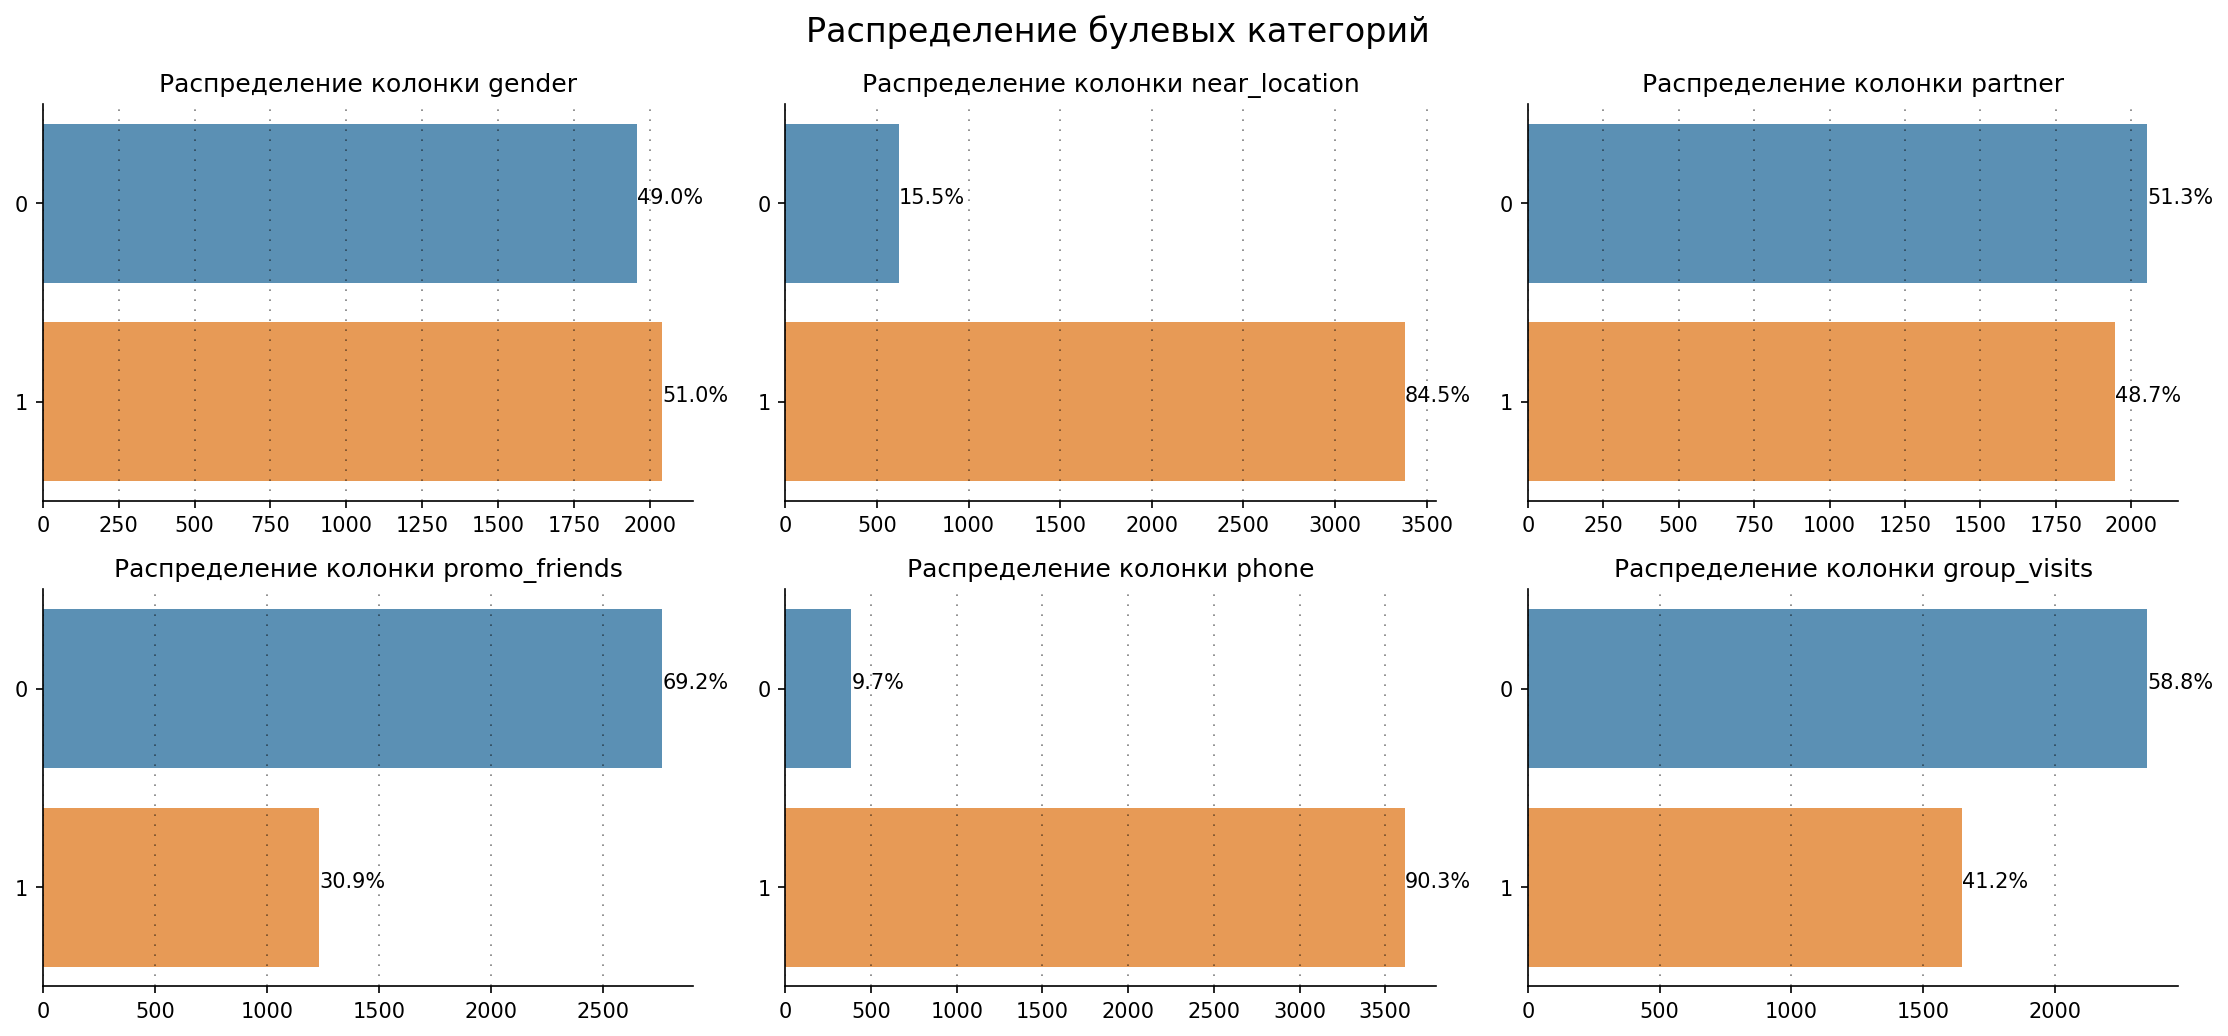

In [12]:
fig = plt.figure(figsize=(15, 7), dpi=150)
total = gym_churn.shape[0]
fig.suptitle('Распределение булевых категорий', fontsize=16)

for i, col in enumerate(bool_cols):
    ax = fig.add_subplot(2, 3, i+1)
    ax = sns.countplot(y=col, data=gym_churn, alpha=0.8)
    ax.grid(b=True, color='black', linestyle=':', axis='x', dashes=(1,5), alpha=0.5)
    ax.set_title('Распределение колонки {}'.format(col))
    ax.set_xlabel('')
    ax.set_ylabel('')

    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width() / total)
        x = p.get_x() + p.get_width()
        y = p.get_y() + p.get_height() / 2
        ax.annotate(percentage, (x, y))

fig.tight_layout()
sns.despine()
plt.show()

Как видно из диаграммы, по полу клиенты распределены практически одинаквово. 84.5% процента пользователей проживают или работают в том же районе, что и фитнес-центр. Чуть меньше половины клиентов - корпоративные. Треть пользователей привели друзья. Интересно, а как указаны корпоративные клиенты в этой категории. Нужно посмотреть. Более 90% пользователей свой телефон оставили. Около 41% клиентов посещают групповые занятия.

Теперь посмотрю на реферальных пользователей и что у них в графе партнер.

In [13]:
gym_churn.groupby(['promo_friends', 'partner'], as_index=False)['gender'].count()

,promo_friends,partner,gender
0,0,0,1837
1,0,1,929
2,1,0,216
3,1,1,1018


Интересно получается. Приведенные друзьями пользователи есть как и в партнерской программе так и вне ее. Думаю, процесс происходит следующим образом: коллега советует другому коллеге фитнес и говорит, что компания оплачивает часть взносов за абоненемент. Таким образом такой пользователь становится одновременно и реферальным и сотрудником компании партнера. Таких пользователей 1018. Я очень пристально рассматриваю реферальных пользователей, потому что распределение ушедших пользователей и количество реферальных очень похоже. Нужно посмотреть корреляцию

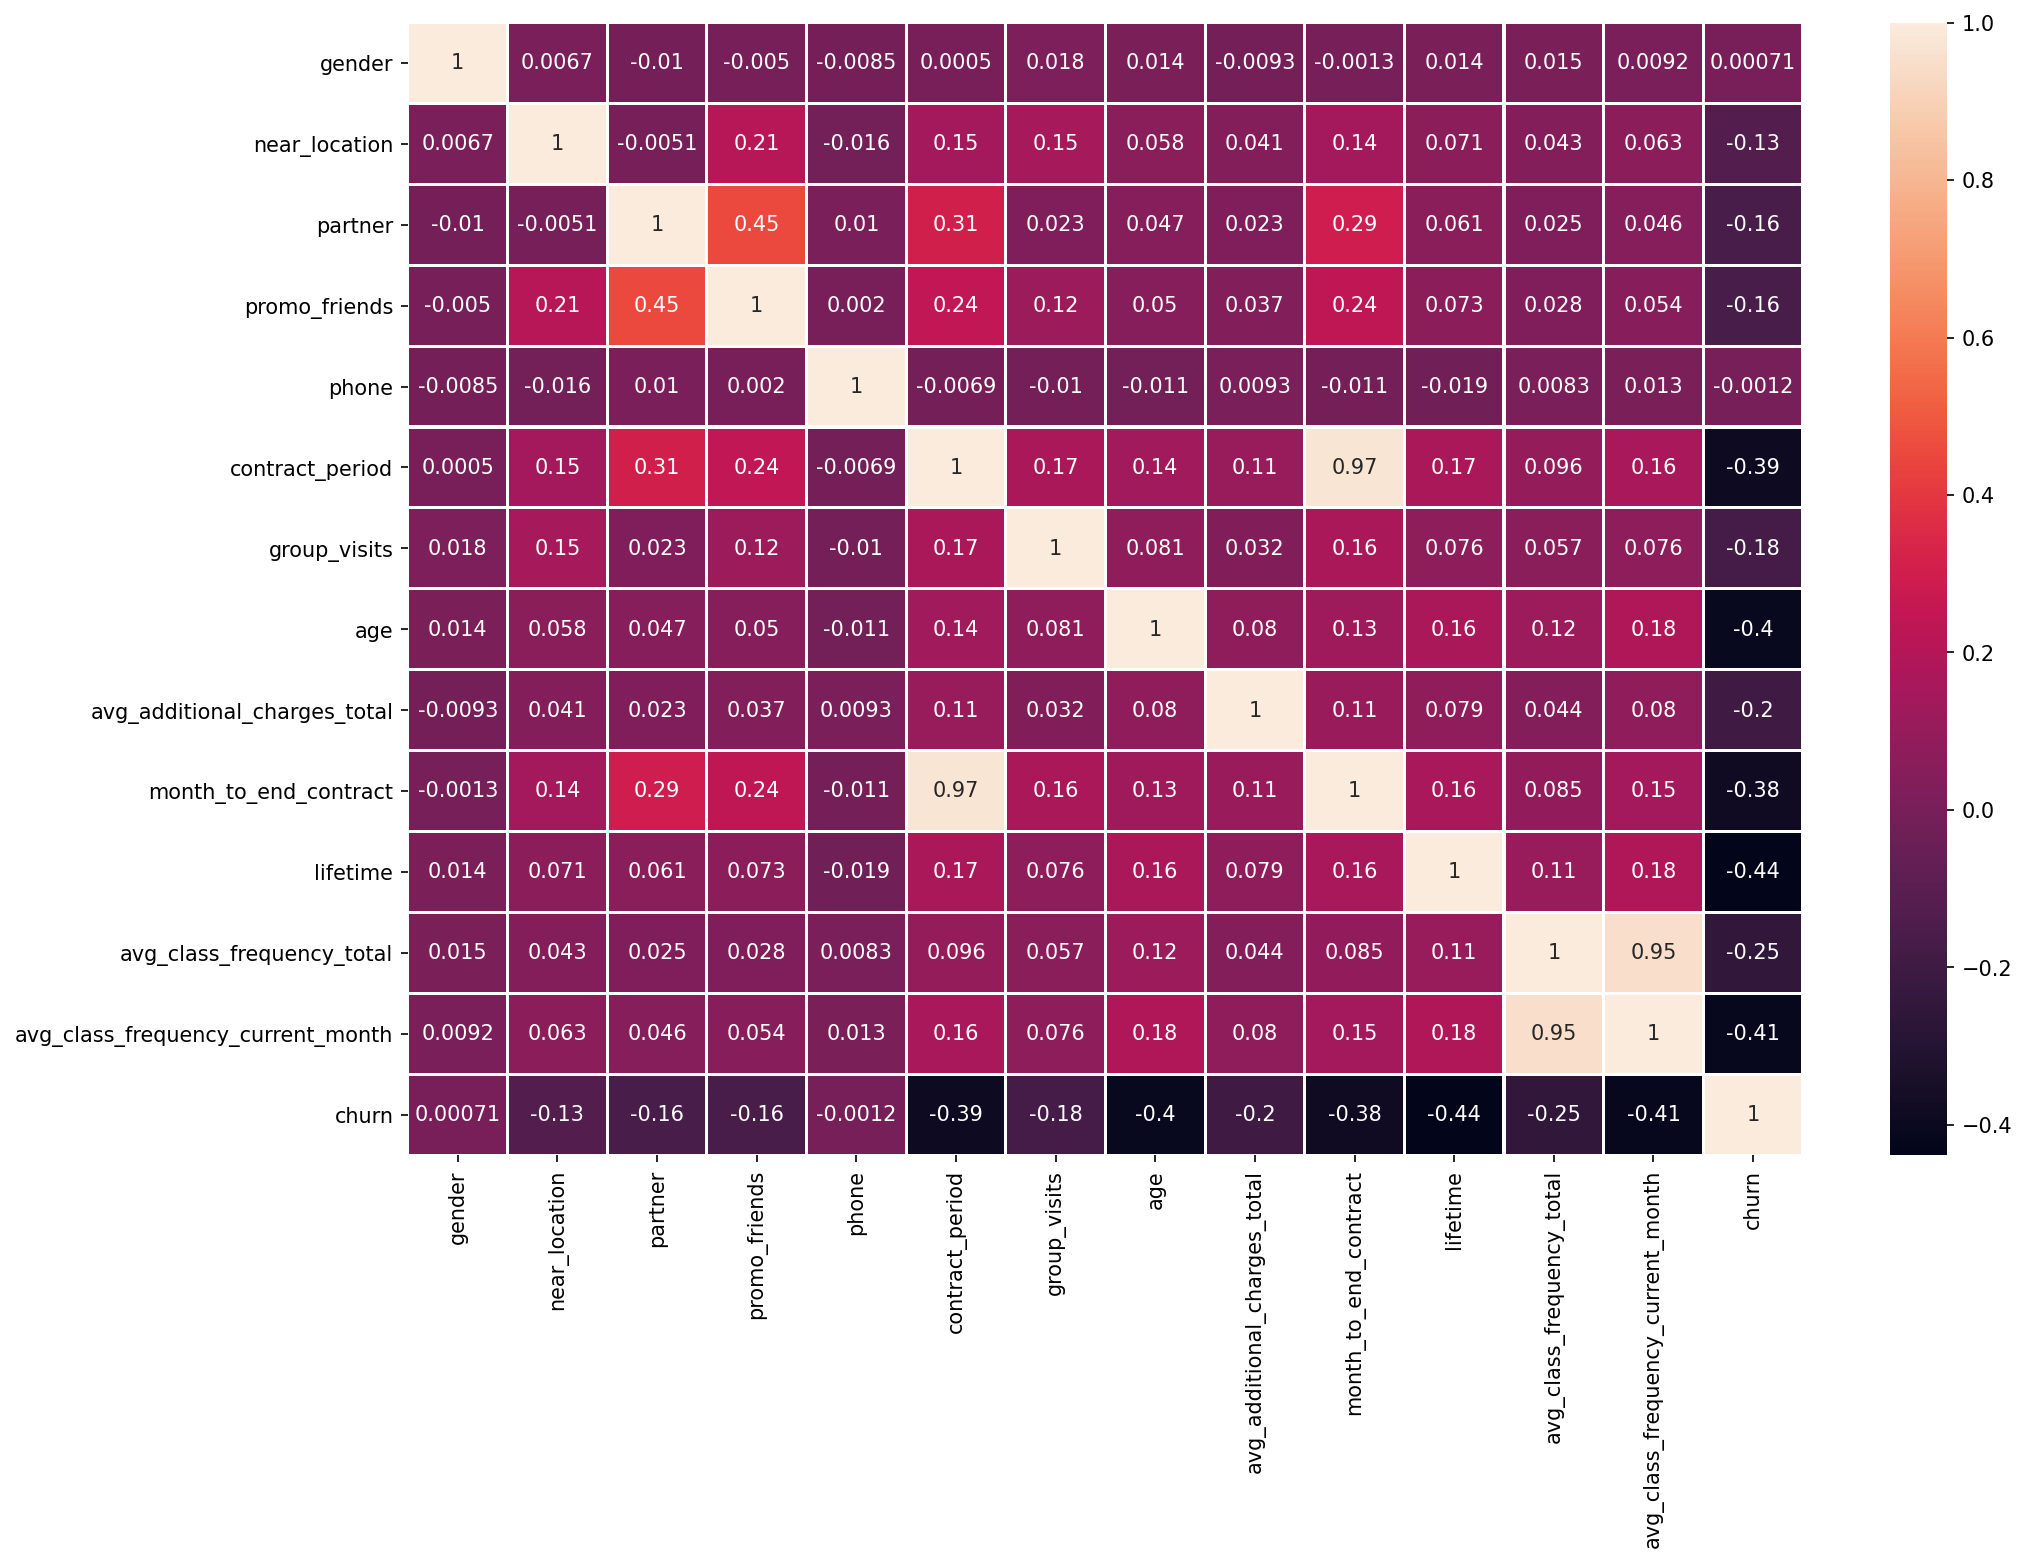

In [14]:
fig = plt.figure(figsize=(15, 10), dpi=150)

sns.heatmap(gym_churn.corr(), annot=True, linewidths=1, linecolor='white')
plt.show()

Видно, что отток пользователей обратно коррелирует с несколькими переменными. Это Средняя частота посещений в неделю за предыдущий месяц, количество месяцев с момента первого обращения в фитнес-центр, возраст и с периодом на который заключен договор. Если говорить о количестве месяцев до конца контракта, то считаю, что данная метрика связана с периодом договора. Это очень хорошо видно на тепловой карте. Корреляция у них аж в 97%

Теперь сравню признаки ушедших и не ушедших.

In [15]:
gym_churn.groupby('churn', as_index=False)[list(gym_churn.columns)].mean().drop('churn', axis=1).T

,0,1
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
contract_period,5.75,1.73
group_visits,0.46,0.27
age,29.98,26.99
avg_additional_charges_total,158.45,115.08
month_to_end_contract,5.28,1.66


Итак отток совершенно не зависит от пола и оставленного номера телефона. Остальные признаки стоит рассмотреть подробнее:  
* По признаку живет или работает клиент в том же районе, где расположен фитнес-центр можно видеть, что неушедших пользователей живущих или работающих там же чуть больше. Очевидно, что это связано с удобством для клиента.  
* Является ли клиент сотрудником компании партнера также различается для обеих групп. И тут все логично. Партнеры платят меньше  
* Ушедших реферальных пользователей мало. Пока не понятно как этот признак влияет на отток. Судя по тепловой карте никак не влияет  
* У ушедших абонемент взят на более короткий срок  
* Опять же ушедшие пользователи чаще всего новые пользователи, поэтому время их "жизни" в зале даже не более единицы. Пришли, посмотрели, не понравилось, ушли  
* Не ушедшие пользователи чаще посещают групповые занятия  
* Ушедшие пользователи в среднем моложе и тратят меньше денег на дополнительные услуги  
* У тех кто остается количество месяцев намного больше. Действительно, если пользователь решил покинуть зал в силу определенных причин, чаще всего он отходит весь свой абонемент и только потом бросит. У ушедших данный признак стремится к единице. То есть они дохаживают последний месяц  
* Ушедшие реже посещают зал  

А теперь визуализирую эти различия

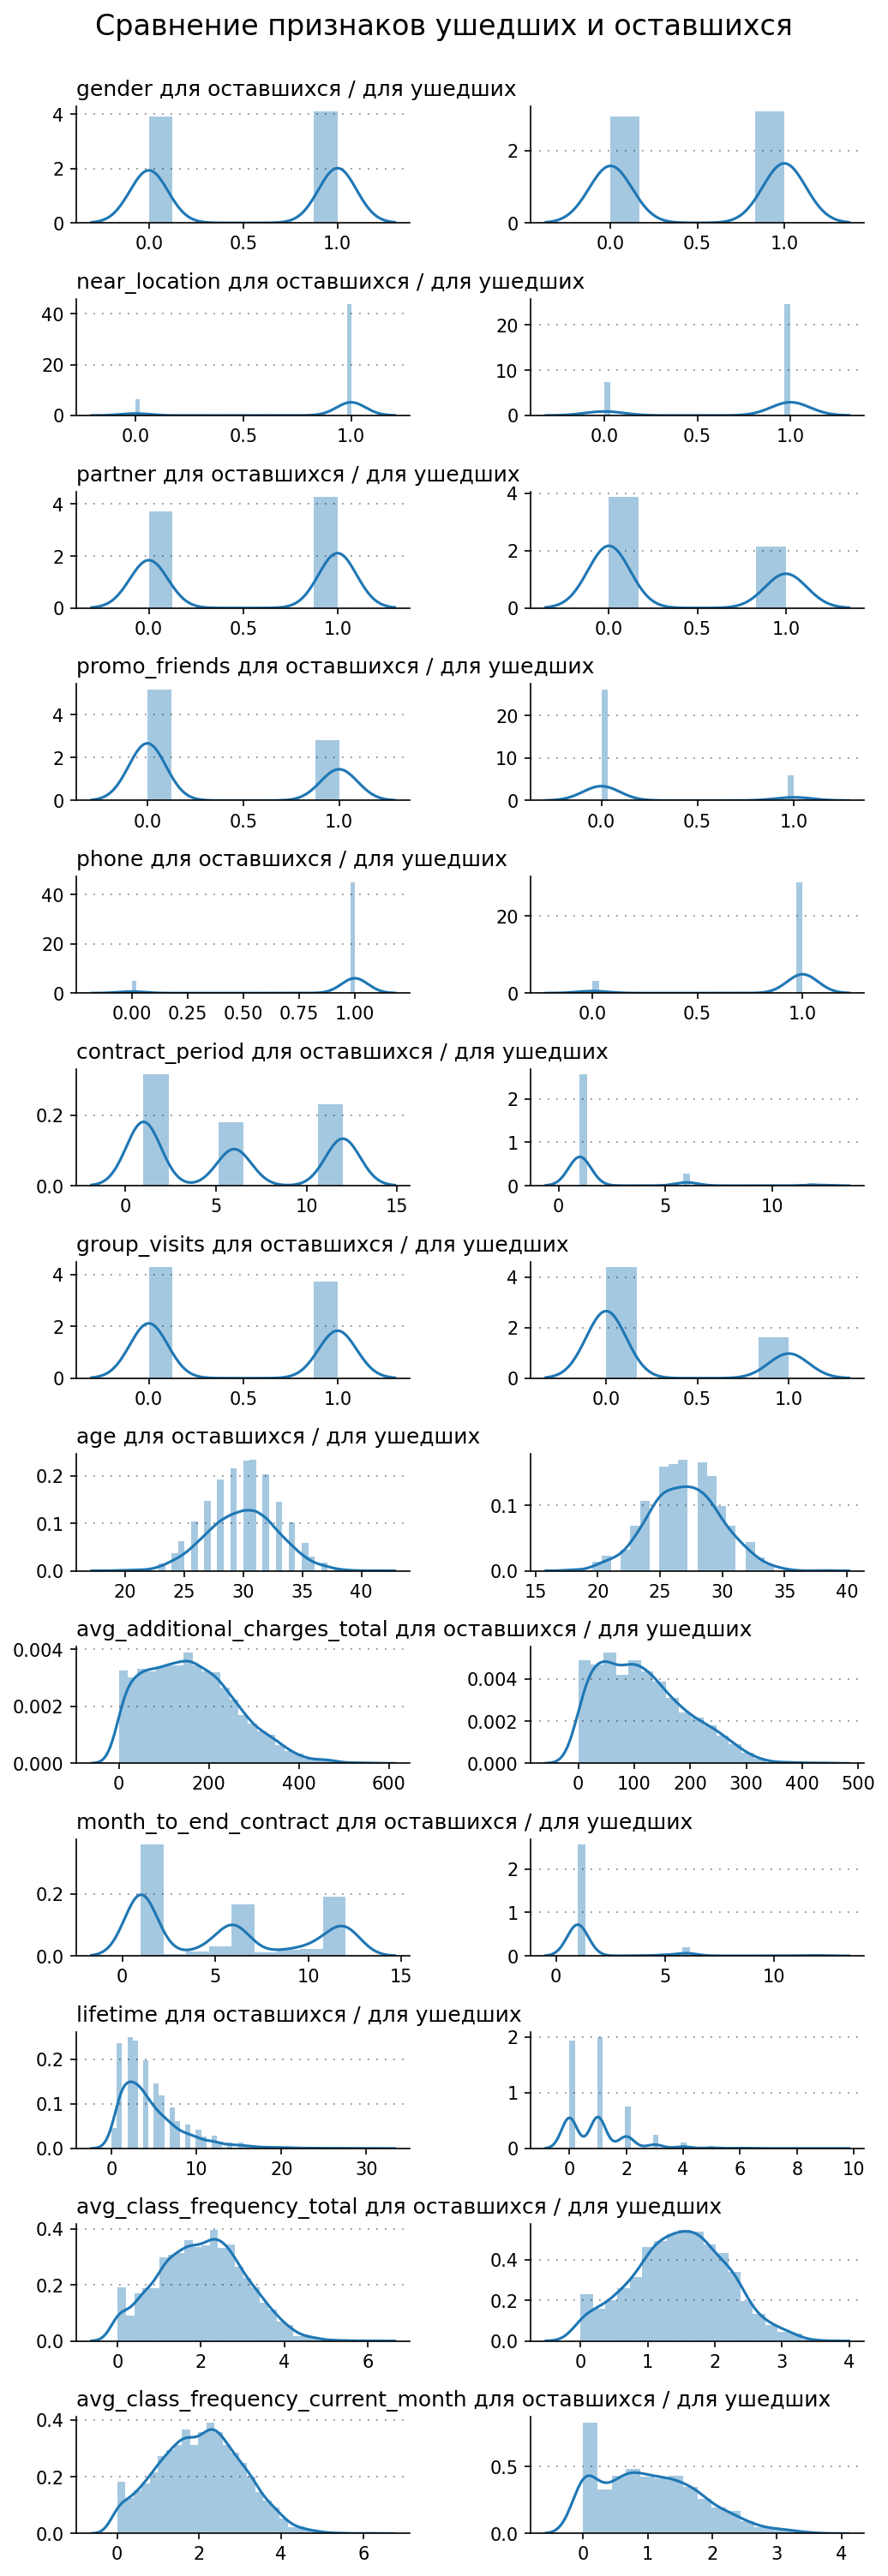

In [16]:
fig = plt.figure(figsize=(7, 20), dpi=150)
fig.suptitle('Сравнение признаков ушедших и оставшихся', fontsize=16, y=1)

for i, col in enumerate(gym_churn.drop('churn', axis=1).columns):
    data = gym_churn[gym_churn['churn'] == 0]
    
    ax = fig.add_subplot(13, 2, i*2+1)
    ax = sns.distplot(a=gym_churn[gym_churn['churn'] == 0][col])
    ax.grid(b=True, color='black', linestyle=':', axis='y', dashes=(1,5), alpha=0.5)
    ax.set_title('{} для оставшихся / для ушедших'.format(col), loc='left')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ax = fig.add_subplot(13, 2, i*2+2)
    ax = sns.distplot(a=gym_churn[gym_churn['churn'] == 1][col])
    ax.grid(b=True, color='black', linestyle=':', axis='y', dashes=(1,5), alpha=0.5)
    ax.set_xlabel('')
    ax.set_ylabel('')

fig.tight_layout()
sns.despine()
plt.show()

Визуализация лишь подтверждает выводы сделанные мной выше.

Итак я определился с признаками которые могут влиять на целевую метрику. Теперь нужно найти лучшую алгоритм.

### 5. Выбор модели и признаки<a id='model_selection'> </a>

Задача представляет собой классическую задачу бинарной классификации с учителем. Для ее решения буду использовать следующие модели:
* Логистическая регрессия  
* Случайный лес  
* Градиентный бустинг   
  
Определю какая из них дает лучший результат, и снова ее обучу подобрав лучшие параметры

Импортирую необходимые библиотеки

In [17]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

Составлю кортеж с моделями

In [18]:
models = (
    LogisticRegression(),
    RandomForestClassifier(),
    GradientBoostingClassifier()
)

И напишу функцию, которая на входе принимает модель, тренировочные и тестовые данные и наименование модели, а возвращает датасет с метриками важностью признаков.  
  
В качестве метрик я решил использовать accuracy_score, precision_score, recall_score, f1_score, roc_auc_score. Классические метрики для классификации

In [19]:
def models_score(model, X_train, y_train, X_test, y_test, model_name):
    model = model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    try:
        features = pd.DataFrame({
            'feature' : list(X_train.columns),
            'coeff' : abs(model.coef_[0])
        })
    except:
        features = pd.DataFrame({
            'feature' : list(X_train.columns),
            'coeff' : model.feature_importances_
        })
    
    report = pd.DataFrame(columns={'accuracy'}, data=[0])
    report['accuracy'] = accuracy_score(y_test, y_pred)
    report['precision'] = precision_score(y_test, y_pred)
    report['recall'] = recall_score(y_test, y_pred)
    report['f1'] = f1_score(y_test, y_pred)
    report['roc_auc'] = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    report.index = [model_name]
    
    print(report)
    print(features.sort_values('coeff', ascending=False))

Определю данные

In [20]:
X = gym_churn.drop('churn', axis=1)

In [21]:
y = gym_churn.churn

И разделю датасет на тренировочные и тестовые данные в пропорции 80 на 20. Rundom state выставлю на 0

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

С помощью цикла проверю все модели

In [23]:
for model in models:
    models_score(model, X_train, y_train, X_test, y_test, str(model))

                      accuracy  precision  recall   f1  roc_auc
LogisticRegression()      0.91       0.83    0.81 0.82     0.96
                              feature  coeff
12  avg_class_frequency_current_month   5.15
11          avg_class_frequency_total   4.50
4                               phone   1.24
10                           lifetime   1.00
3                       promo_friends   0.76
6                        group_visits   0.39
9               month_to_end_contract   0.23
0                              gender   0.15
1                       near_location   0.10
7                                 age   0.10
2                             partner   0.07
5                     contract_period   0.03
8        avg_additional_charges_total   0.00
                          accuracy  precision  recall   f1  roc_auc
RandomForestClassifier()      0.92       0.85    0.80 0.82     0.97
                              feature  coeff
10                           lifetime   0.29
12  avg_class_fr

Лучшие результаты у **GradientBoostingClassifier**. Выберу эту модель для обучения

Если говорить о важности признаков, то важнейшим признаком Логистическая регрессия считает частоту посещения. Общую и за последний месяц. Эти два признака имеют наибольший коэффициент. Далее почему-то следует телефон, что странно. Потом время жизни.  
  
Ансамбли же считают важнейшим признаком время жизни, дале следует частота посещения, а телефон вообще не влияет. Возраст влияет, но не сильно

### 6. Обучение лучшей модели <a id='best_model'> </a>

Немного подтяну метрику обучения. Думаю, это даст лучший результат

In [24]:
gb_clf = GradientBoostingClassifier(learning_rate=0.3)

In [25]:
gb_clf.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.3)

In [26]:
y_pred = gb_clf.predict(X_test)

In [27]:
best_model_report = pd.DataFrame(columns={'accuracy'}, data=[0])
best_model_report['accuracy'] = accuracy_score(y_test, y_pred)
best_model_report['precision'] = precision_score(y_test, y_pred)
best_model_report['recall'] = recall_score(y_test, y_pred)
best_model_report['f1'] = f1_score(y_test, y_pred)
best_model_report['roc_auc'] = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

best_model_report.index = ['best_model']

In [28]:
best_model_report

,accuracy,precision,recall,f1,roc_auc
best_model,0.95,0.89,0.89,0.89,0.98


Как я и предполагал, немного измененные настройки дали хороший результат.

In [29]:
best_model_features = pd.DataFrame({
            'feature' : list(X_train.columns),
            'coeff' : gb_clf.feature_importances_
        }).sort_values('coeff', ascending=False)

In [30]:
best_model_features

,feature,coeff
10,lifetime,0.46
12,avg_class_frequency_current_month,0.18
11,avg_class_frequency_total,0.11
7,age,0.09
9,month_to_end_contract,0.09
8,avg_additional_charges_total,0.03
5,contract_period,0.03
6,group_visits,0.01
3,promo_friends,0.00
1,near_location,0.00


Итак самым важным признаком можно признать "время жизни" пользователя. Чем дольше он ходит, тем он более лоялен. Далее идет частота посещения. Если человеку нравится спорт и услуги, которые предлагает зал, то и заниматься он будет чаще. Возраст это неочевидный признак. Он не так весом, но все же стоит на чертвертом месте. В ходе feature_engineering мной было выявлено, что чаще уходят молодые пользователи, что тут и подтвердилось. Взросыле люди не так охотно меняют привычный уклад. Далее идет период договора. Моделирование показало, что этот признак не так важен как казалось. Можно предположить, что люди покупают абонемент воодушевленные измениться, но запал их падает и они перестают посещать фитнес. И даже потраченные деньги не становятся мотиватором продолжать.

### 7. Кластеризация <a id='clusterization'> </a>

Также стоит задача в класстеризации клиентов фитнес-центра. Сначала стандартизирую данные. Для этого воспользуюсь StandardScaller. Импортрую все что необходимо

In [31]:
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [32]:
scaler = StandardScaler()

In [33]:
x_sc = scaler.fit_transform(gym_churn.drop(columns = ['churn']))

In [34]:
linked = linkage(x_sc, method = 'ward')

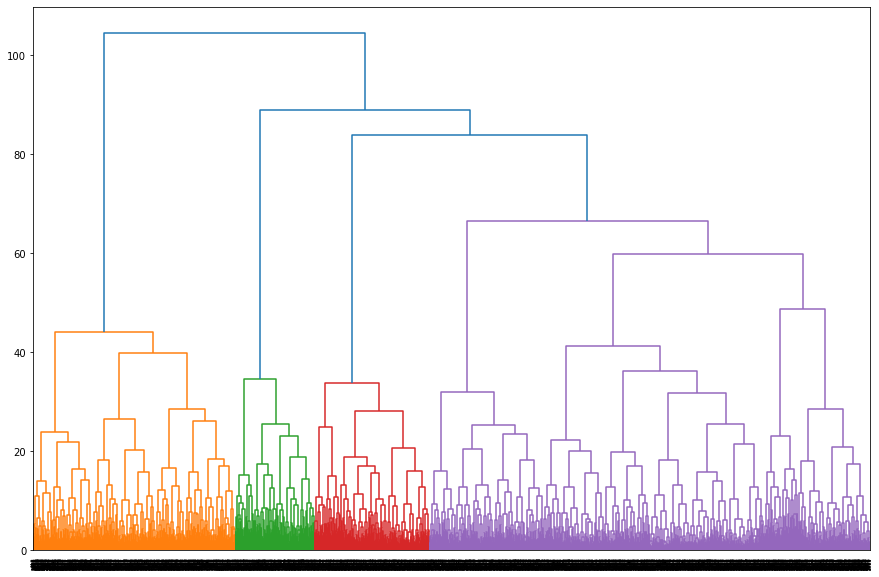

In [35]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show()

Итого получилось 4 кластера. Но фиолетовый кластер очень большой. Возможно стоит его рассматривать как два отдельных по наивысшей ветке. Итого получится 5 кластеров.  
  
Теперь модель K-Means

In [36]:
km = KMeans(n_clusters = 5)

In [37]:
labels = km.fit_predict(x_sc)

In [38]:
gym_churn['clusters_km'] = labels

In [39]:
gym_churn.groupby('clusters_km', as_index=False)[list(gym_churn.columns)].mean().drop(['churn', 'clusters_km'], axis=1).T

,0,1,2,3,4
gender,0.50,0.55,0.50,0.49,0.52
near_location,0.95,0.85,0.94,0.72,0.86
partner,0.83,0.26,0.74,0.30,0.47
promo_friends,1.00,0.05,0.48,0.02,0.31
phone,1.00,1.00,1.00,1.00,0.00
contract_period,3.08,2.60,11.85,1.91,4.78
group_visits,0.45,0.44,0.55,0.28,0.43
age,29.12,30.01,29.89,28.09,29.30
avg_additional_charges_total,141.84,159.80,163.42,129.54,144.21
month_to_end_contract,2.88,2.43,10.80,1.82,4.47


Первая группа, это те люди, которые не оставили свой телефон. В четвертую группу входят те, кто не живет или работает в том же районе, где расположен фитнес-центр. Во второй группе контрактный период самый долгий. В третьей группе самые долгожители и самые взрослые. Еще они тратят больше всех на дополнительные услуги. В пятой группе, только те клиенты, которые живут или работают в том же районе и при этом у них самый короткий контракт и они моложе остальных групп.

Теперь посмотрю на распределения признаков для кластеров. Для этого напишу функцию, которая на вход будет принимать колонку, и выдавать распределение для разных кластеров

In [40]:
def cluster_features(feature):
    fig = plt.figure(figsize=(15, 10), dpi=150)
    fig.suptitle('Сравнение кластеров по признаку {}'.format(feature), fontsize=16, y=1)
    
    ax = fig.add_subplot(3, 2, 1)
    ax = sns.distplot(a=gym_churn[gym_churn['clusters_km'] == 0][feature])
    ax.grid(b=True, color='black', linestyle=':', axis='y', dashes=(1,5), alpha=0.5)
    ax.set_title('Кластер 0', loc='left')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ax = fig.add_subplot(3, 2, 2)
    ax = sns.distplot(a=gym_churn[gym_churn['clusters_km'] == 1][feature])
    ax.grid(b=True, color='black', linestyle=':', axis='y', dashes=(1,5), alpha=0.5)
    ax.set_title('Кластер 1', loc='left')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ax = fig.add_subplot(3, 2, 3)
    ax = sns.distplot(a=gym_churn[gym_churn['clusters_km'] == 2][feature])
    ax.grid(b=True, color='black', linestyle=':', axis='y', dashes=(1,5), alpha=0.5)
    ax.set_title('Кластер 2', loc='left')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ax = fig.add_subplot(3, 2, 4)
    ax = sns.distplot(a=gym_churn[gym_churn['clusters_km'] == 3][feature])
    ax.grid(b=True, color='black', linestyle=':', axis='y', dashes=(1,5), alpha=0.5)
    ax.set_title('Кластер 3', loc='left')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ax = fig.add_subplot(3, 2, 5)
    ax = sns.distplot(a=gym_churn[gym_churn['clusters_km'] == 4][feature])
    ax.grid(b=True, color='black', linestyle=':', axis='y', dashes=(1,5), alpha=0.5)
    ax.set_title('Кластер 4', loc='left')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    fig.tight_layout()
    sns.despine()
    plt.show()

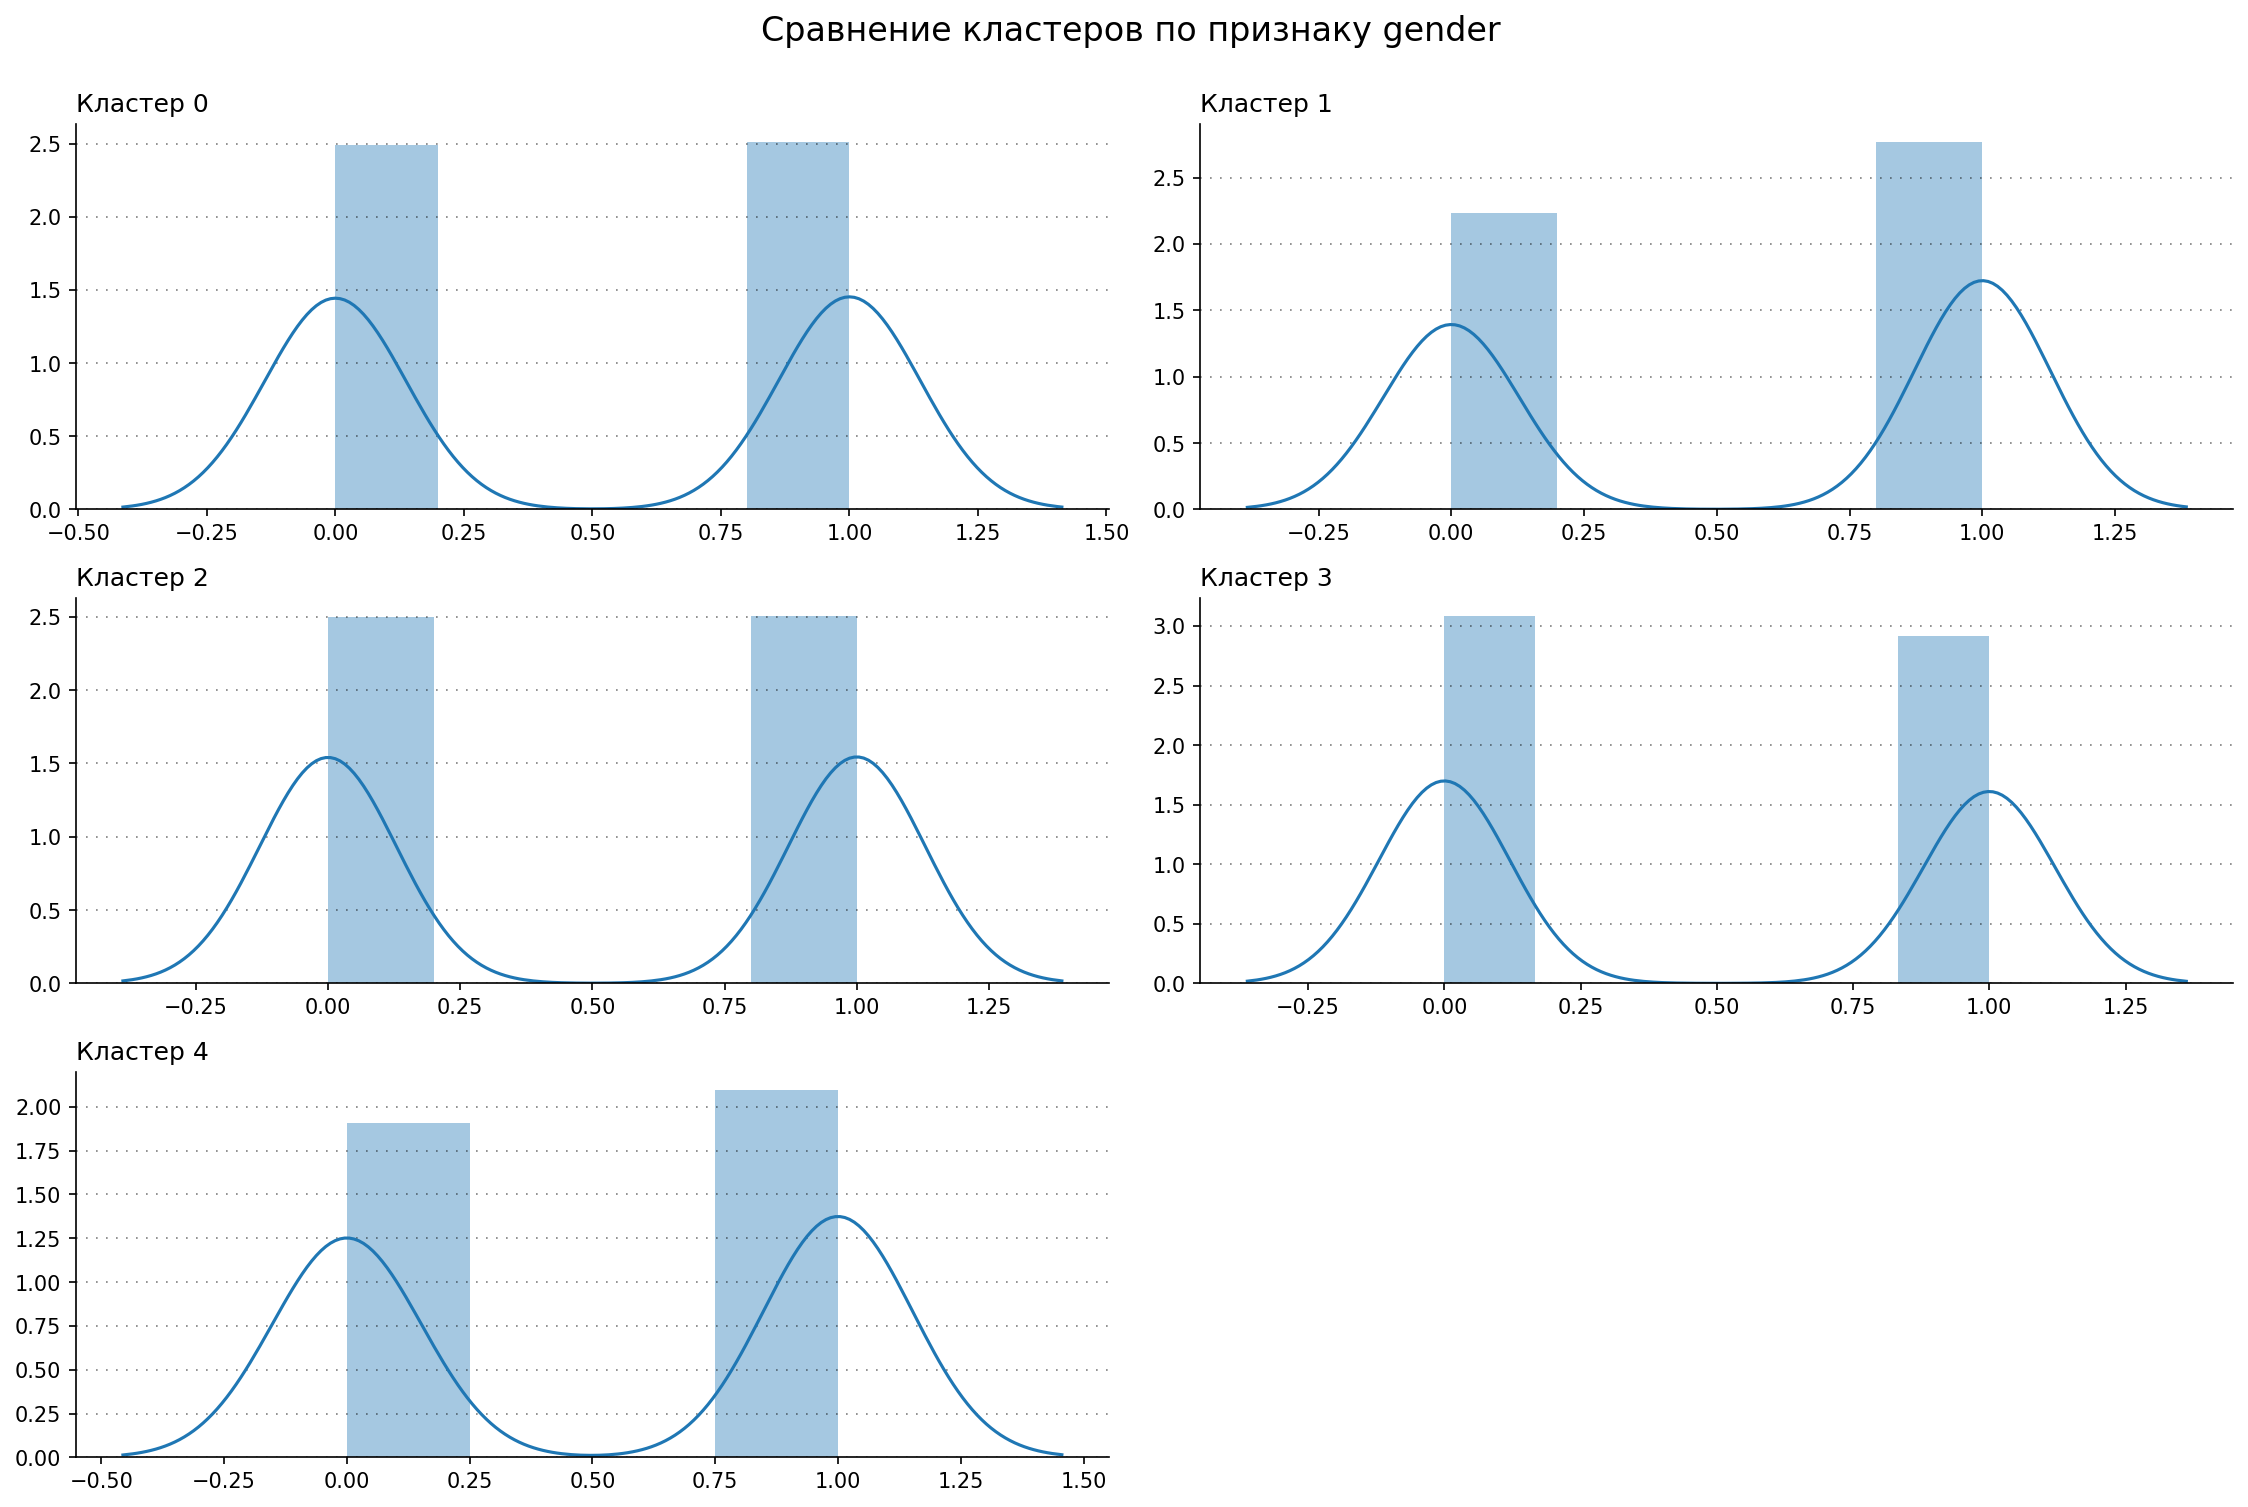

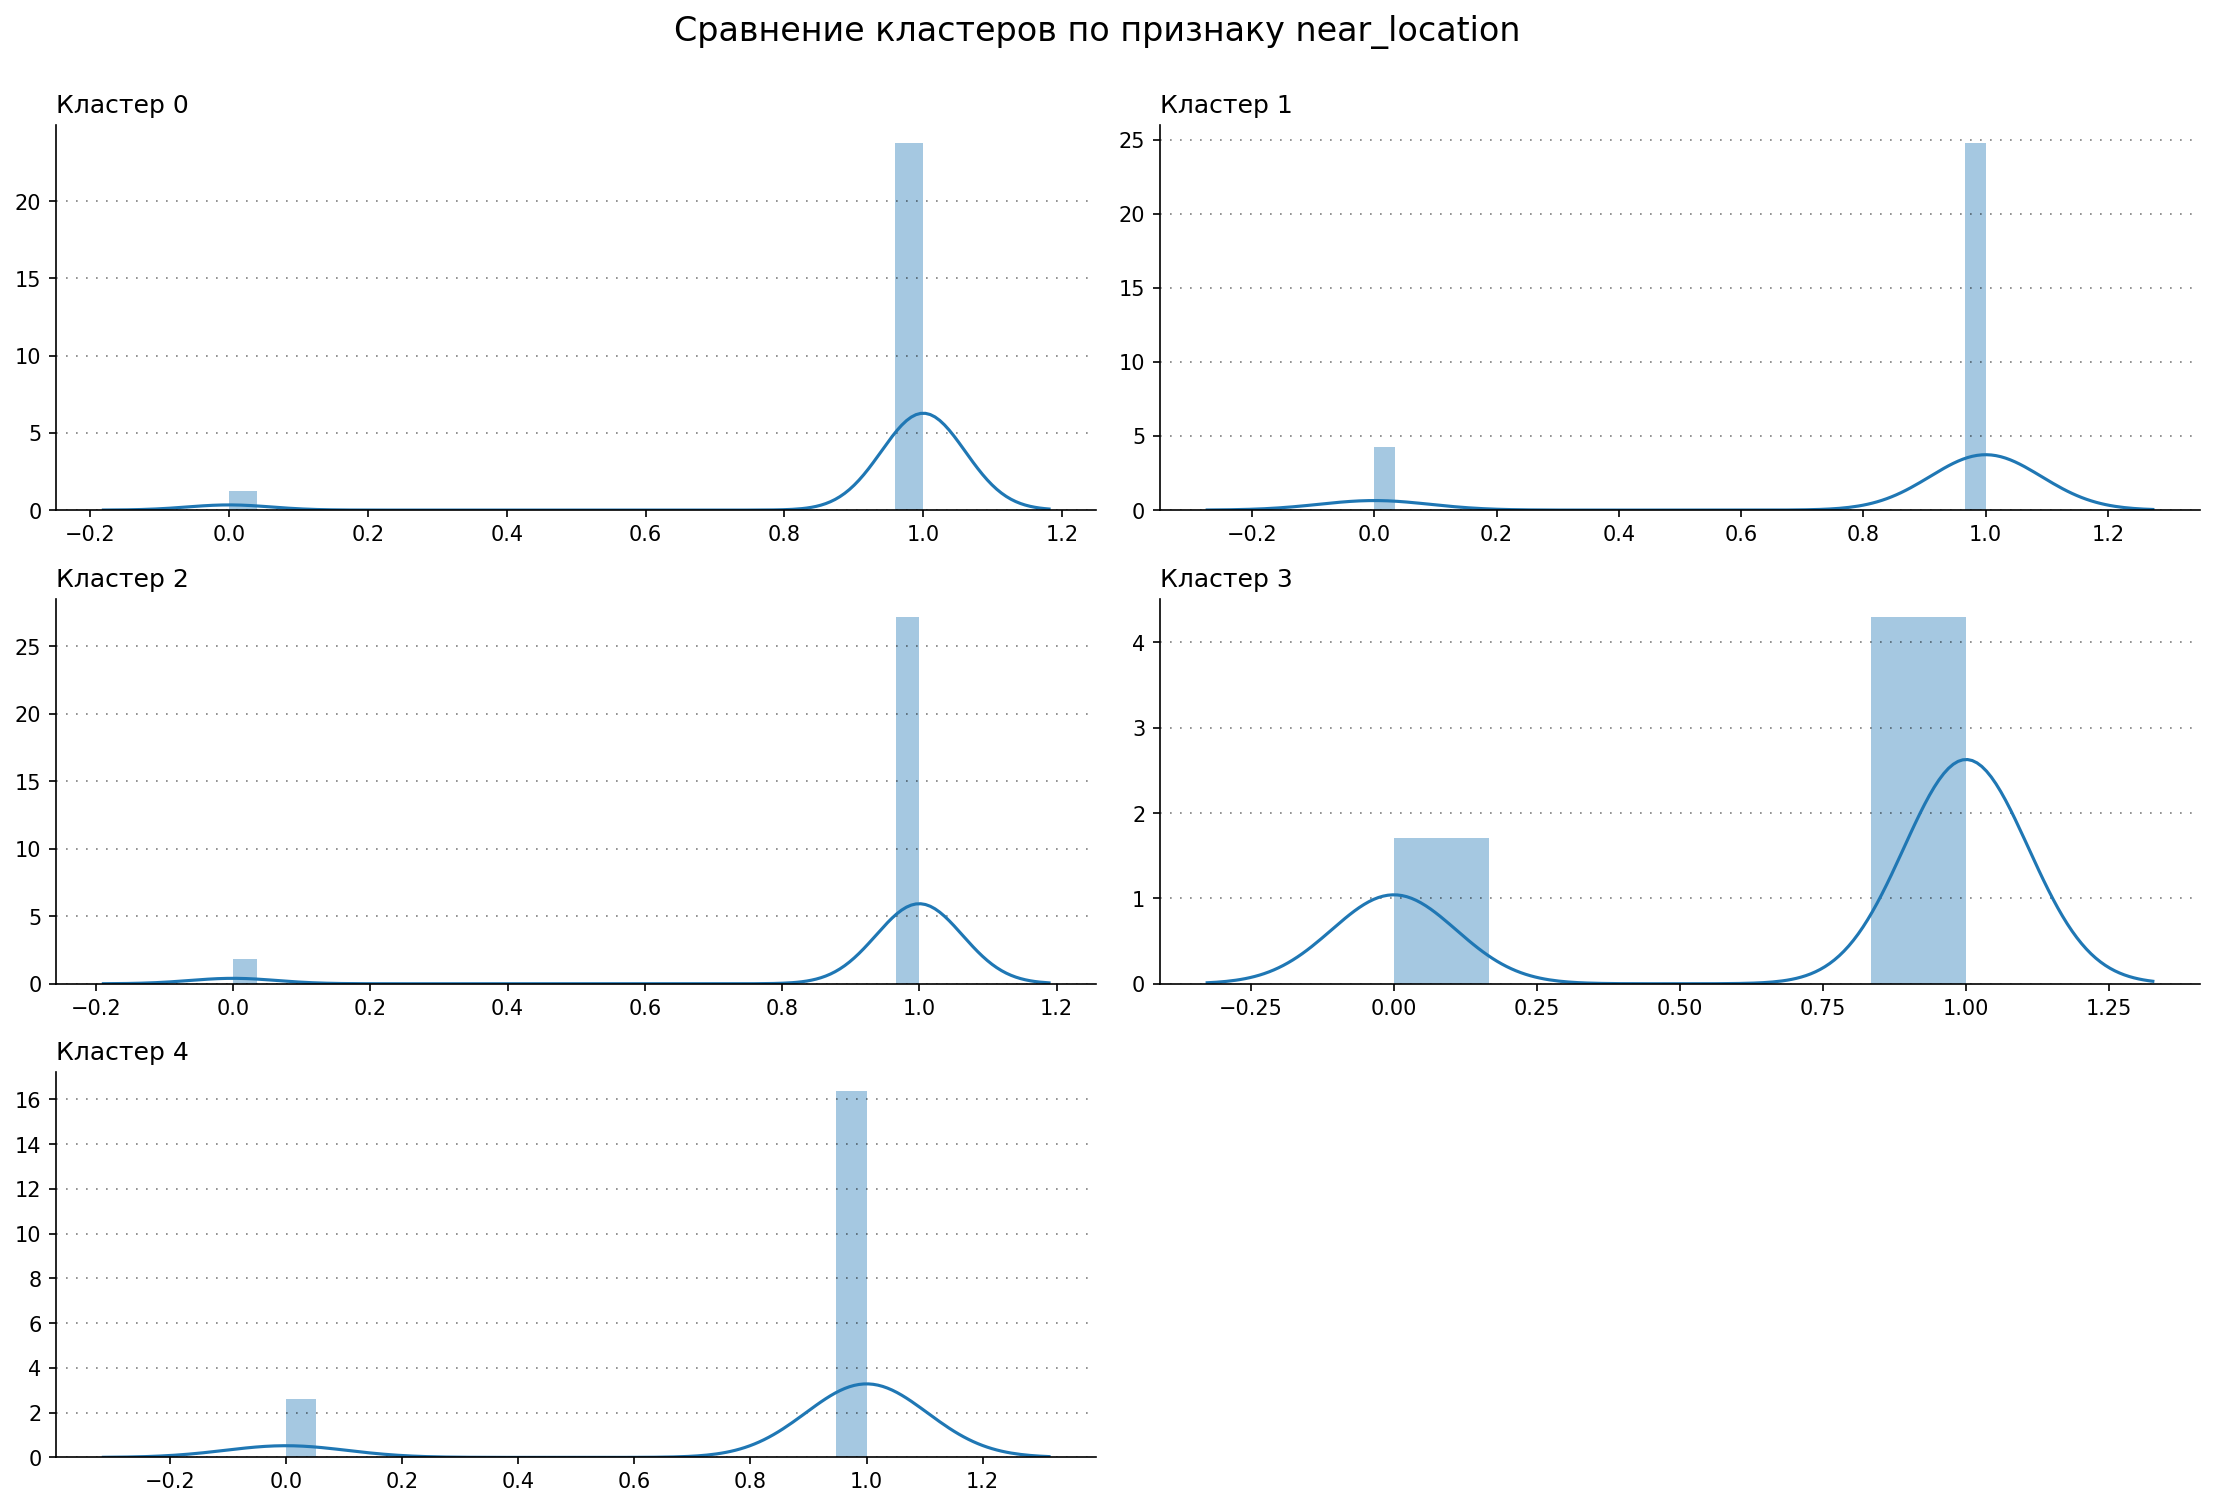

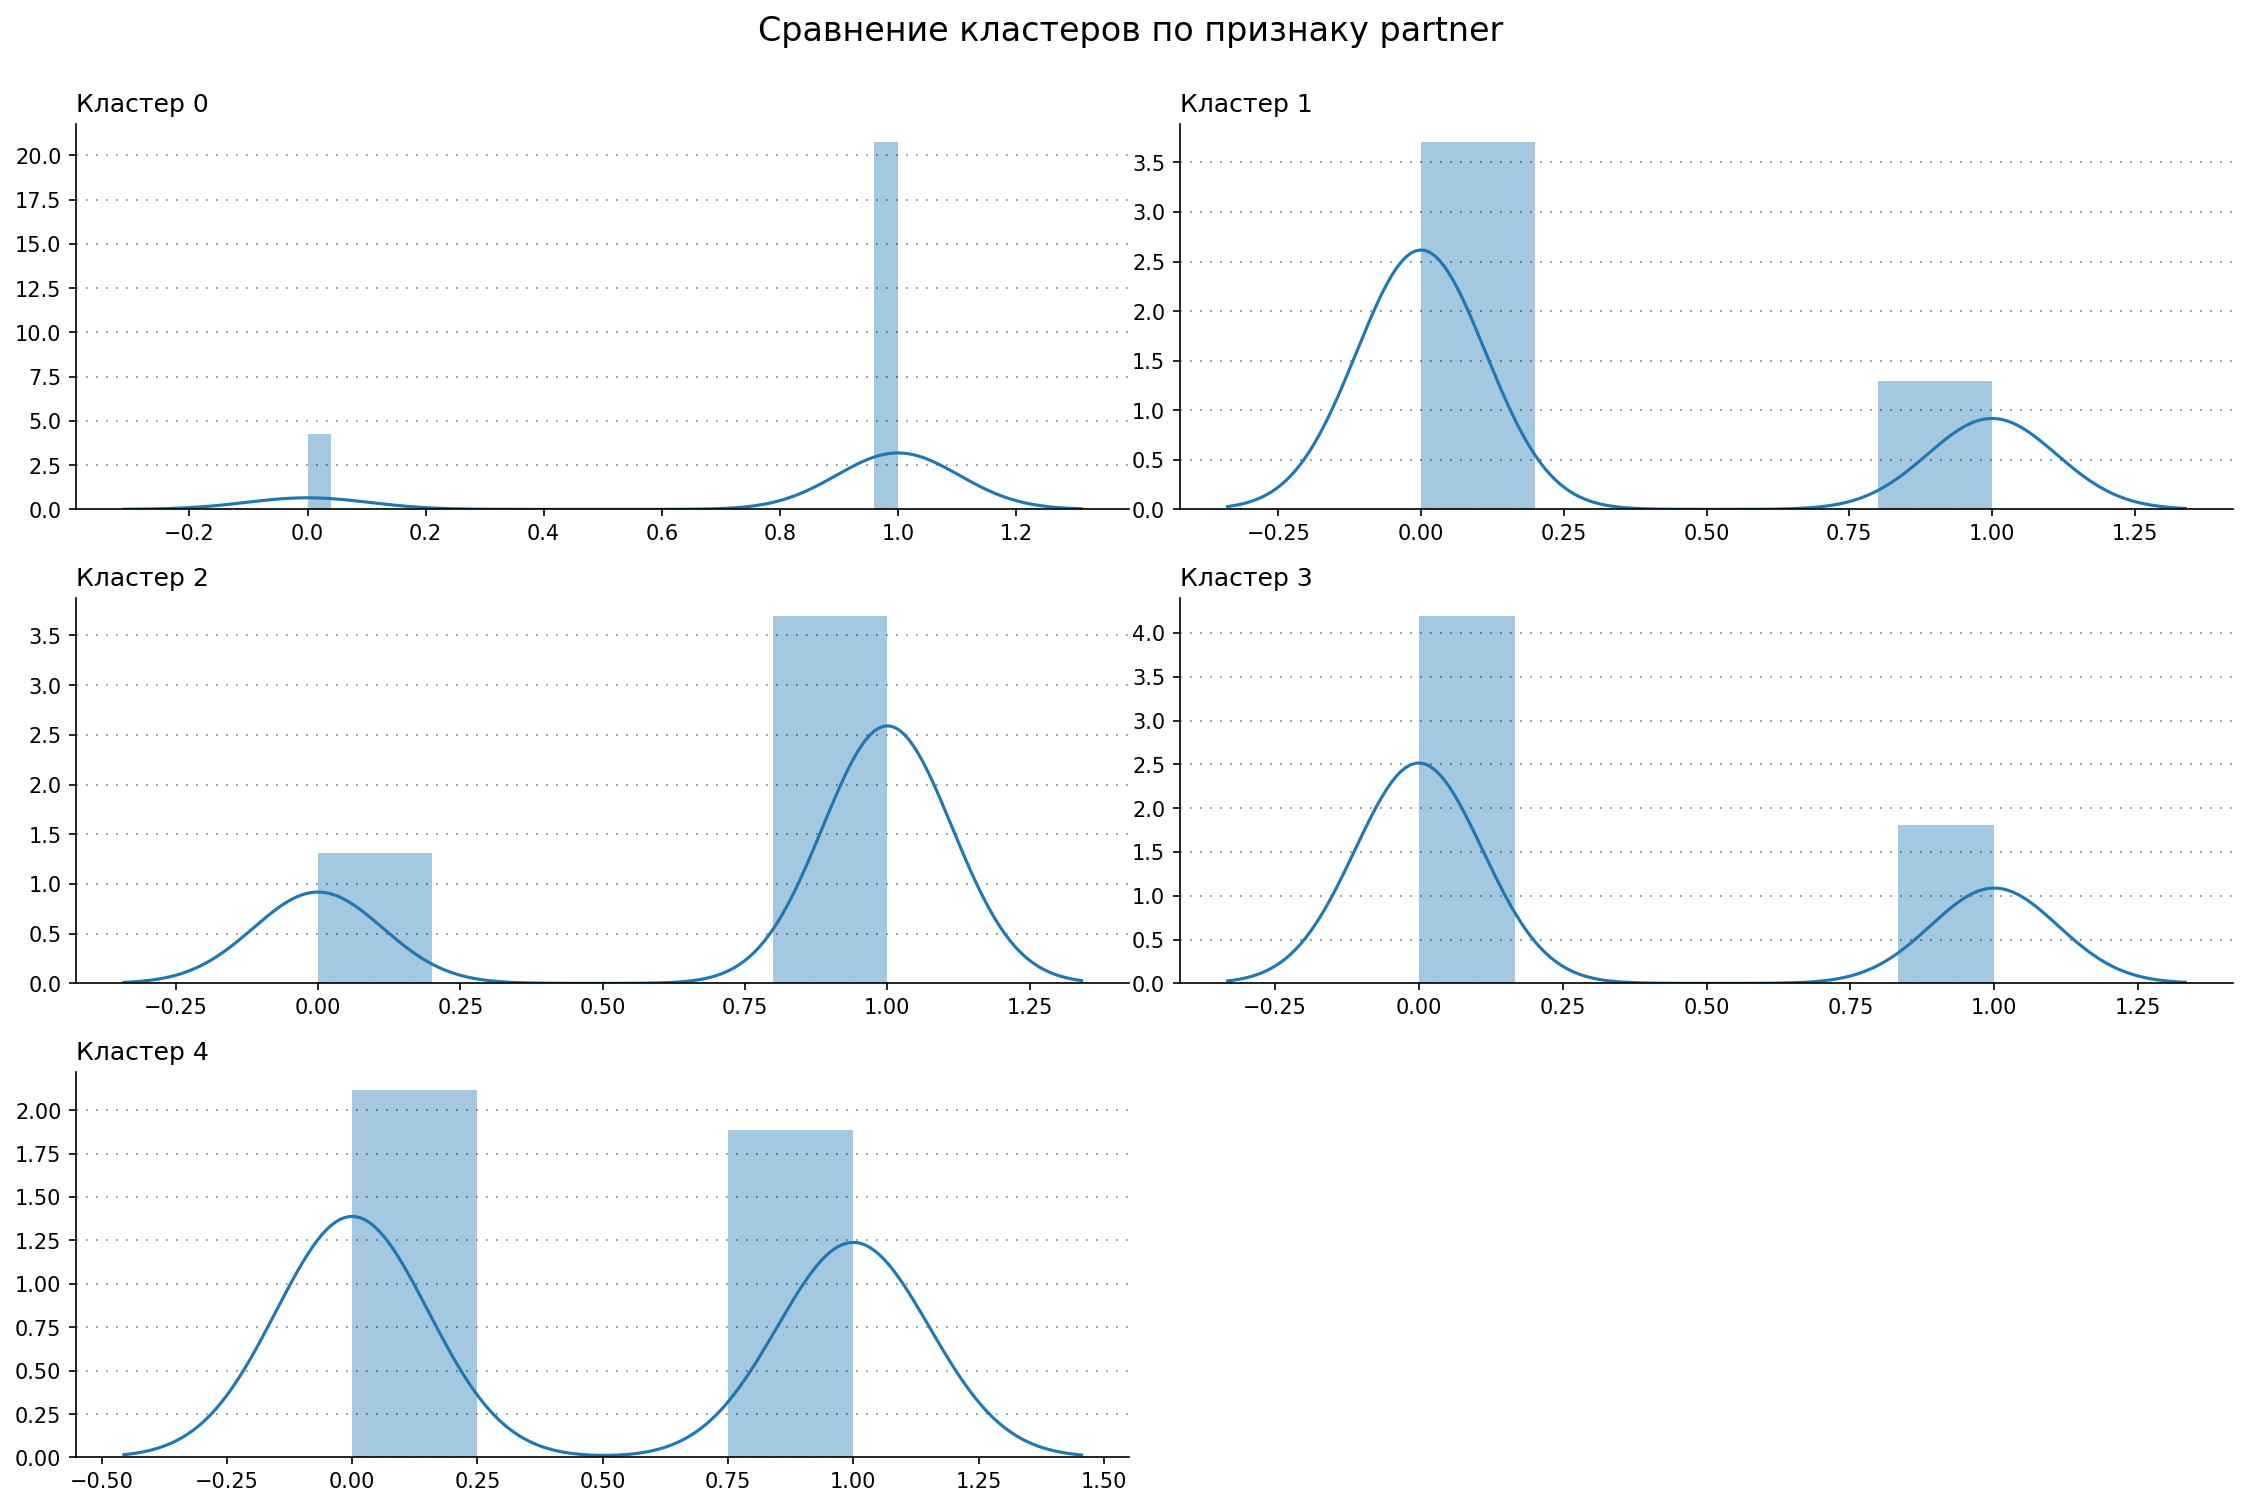

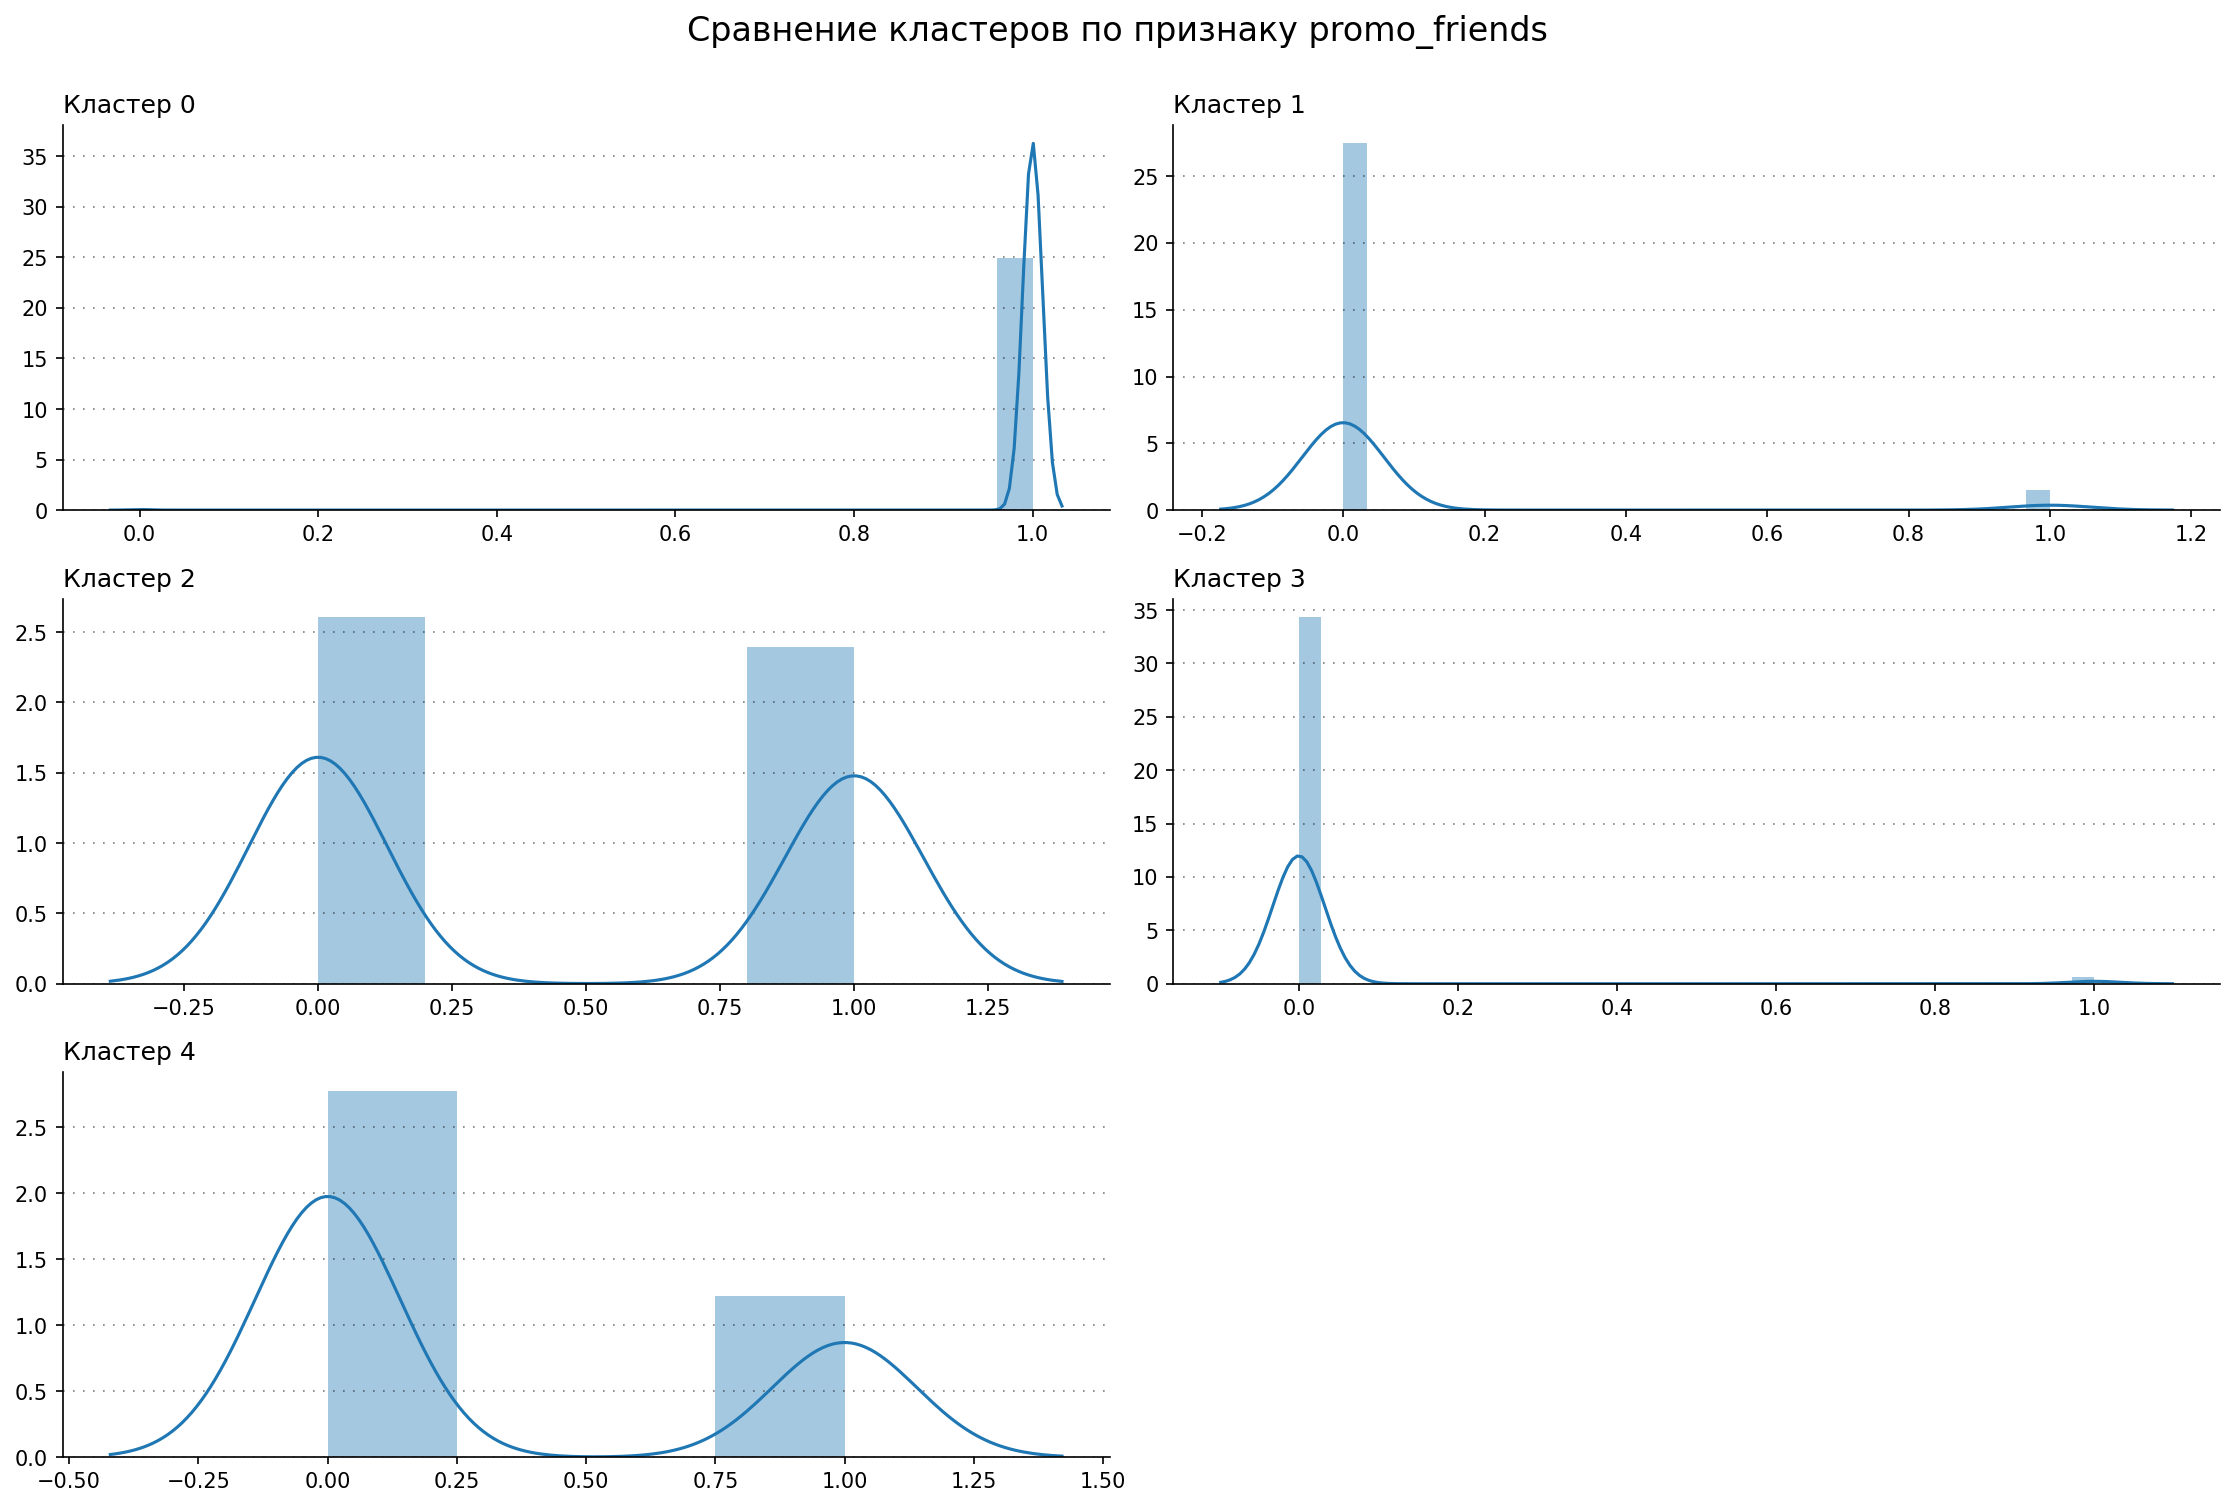

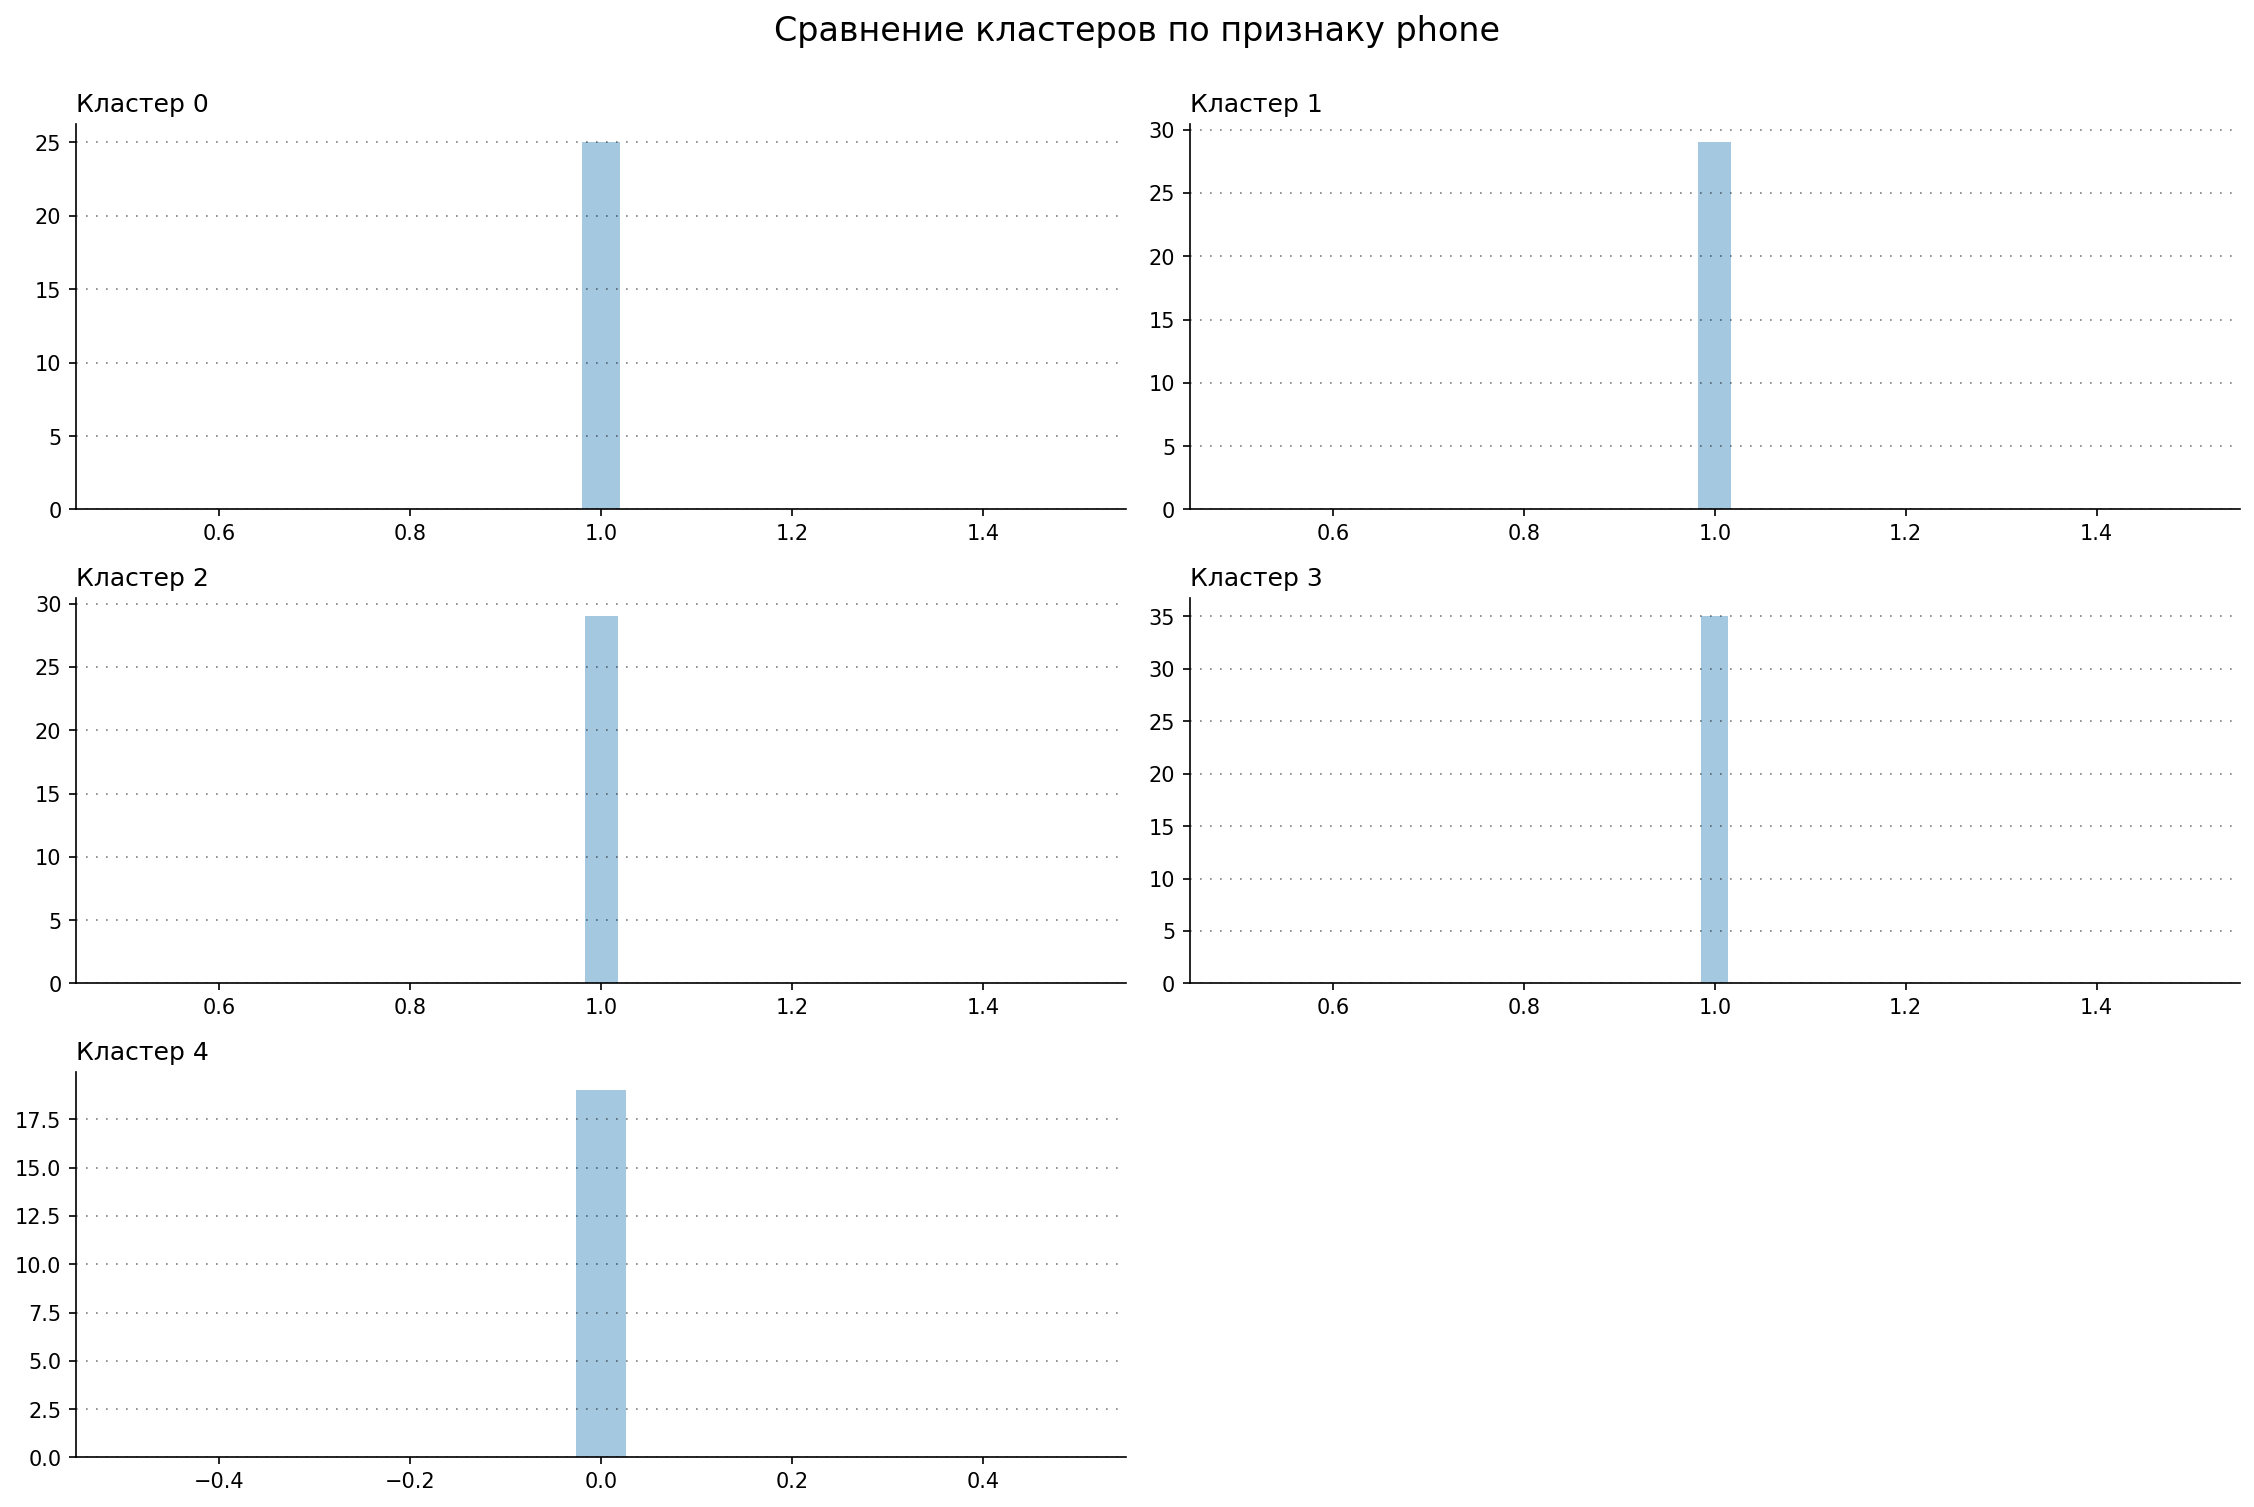

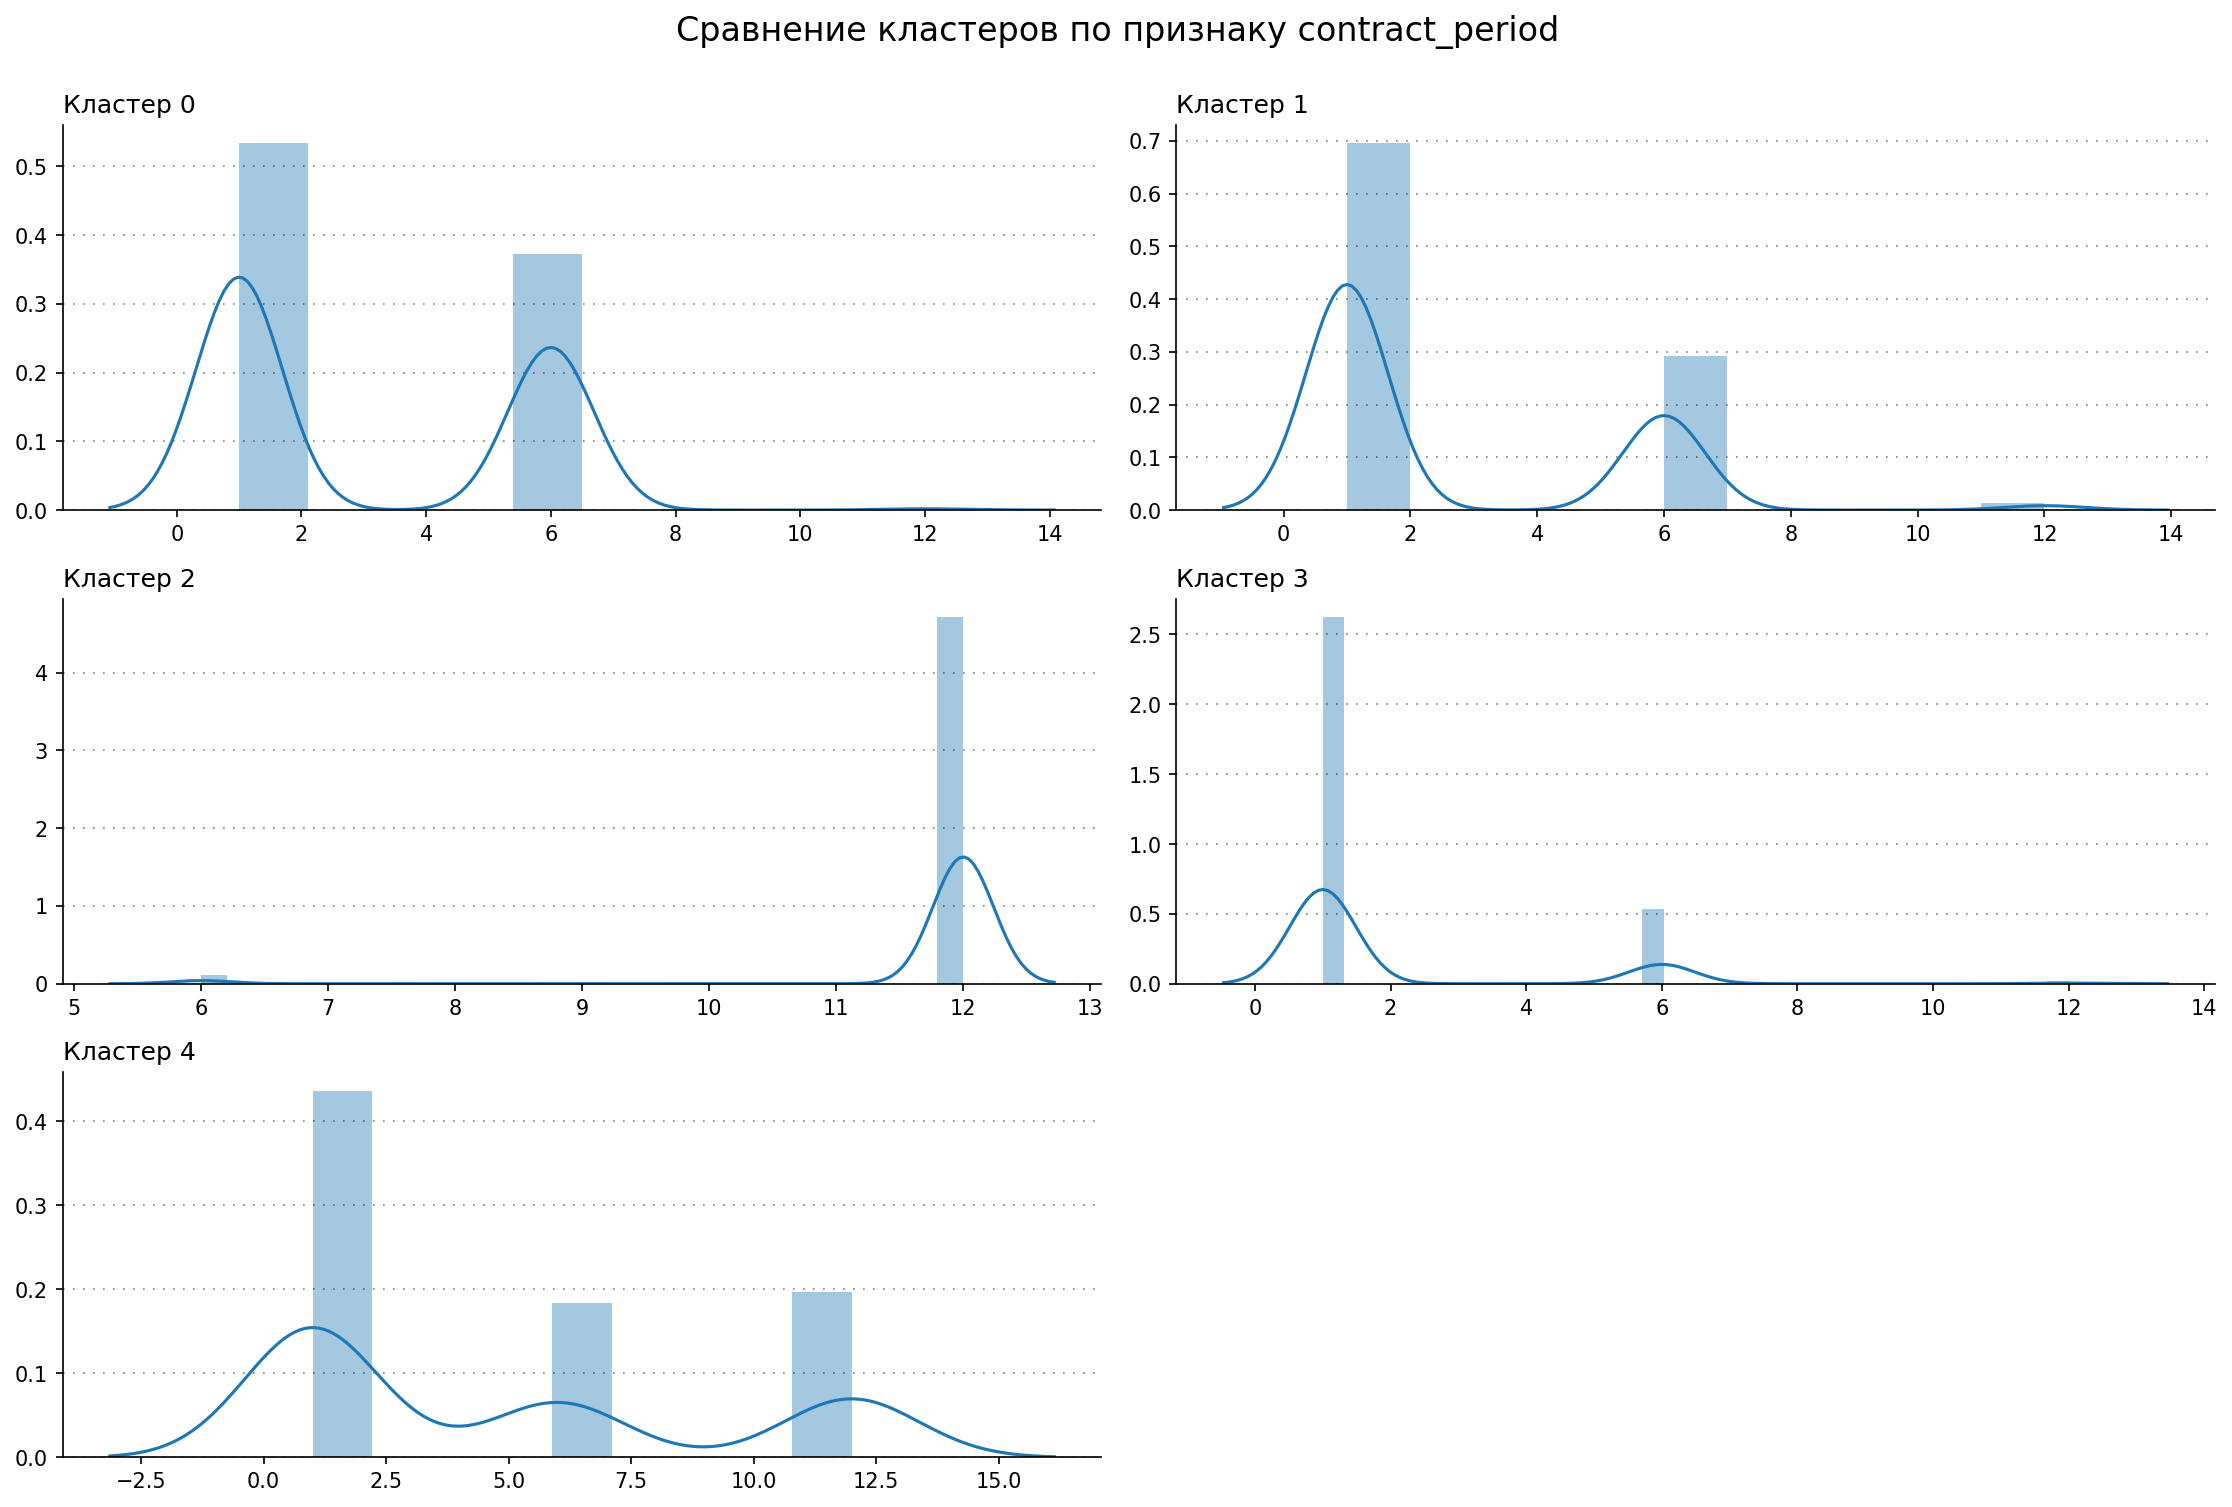

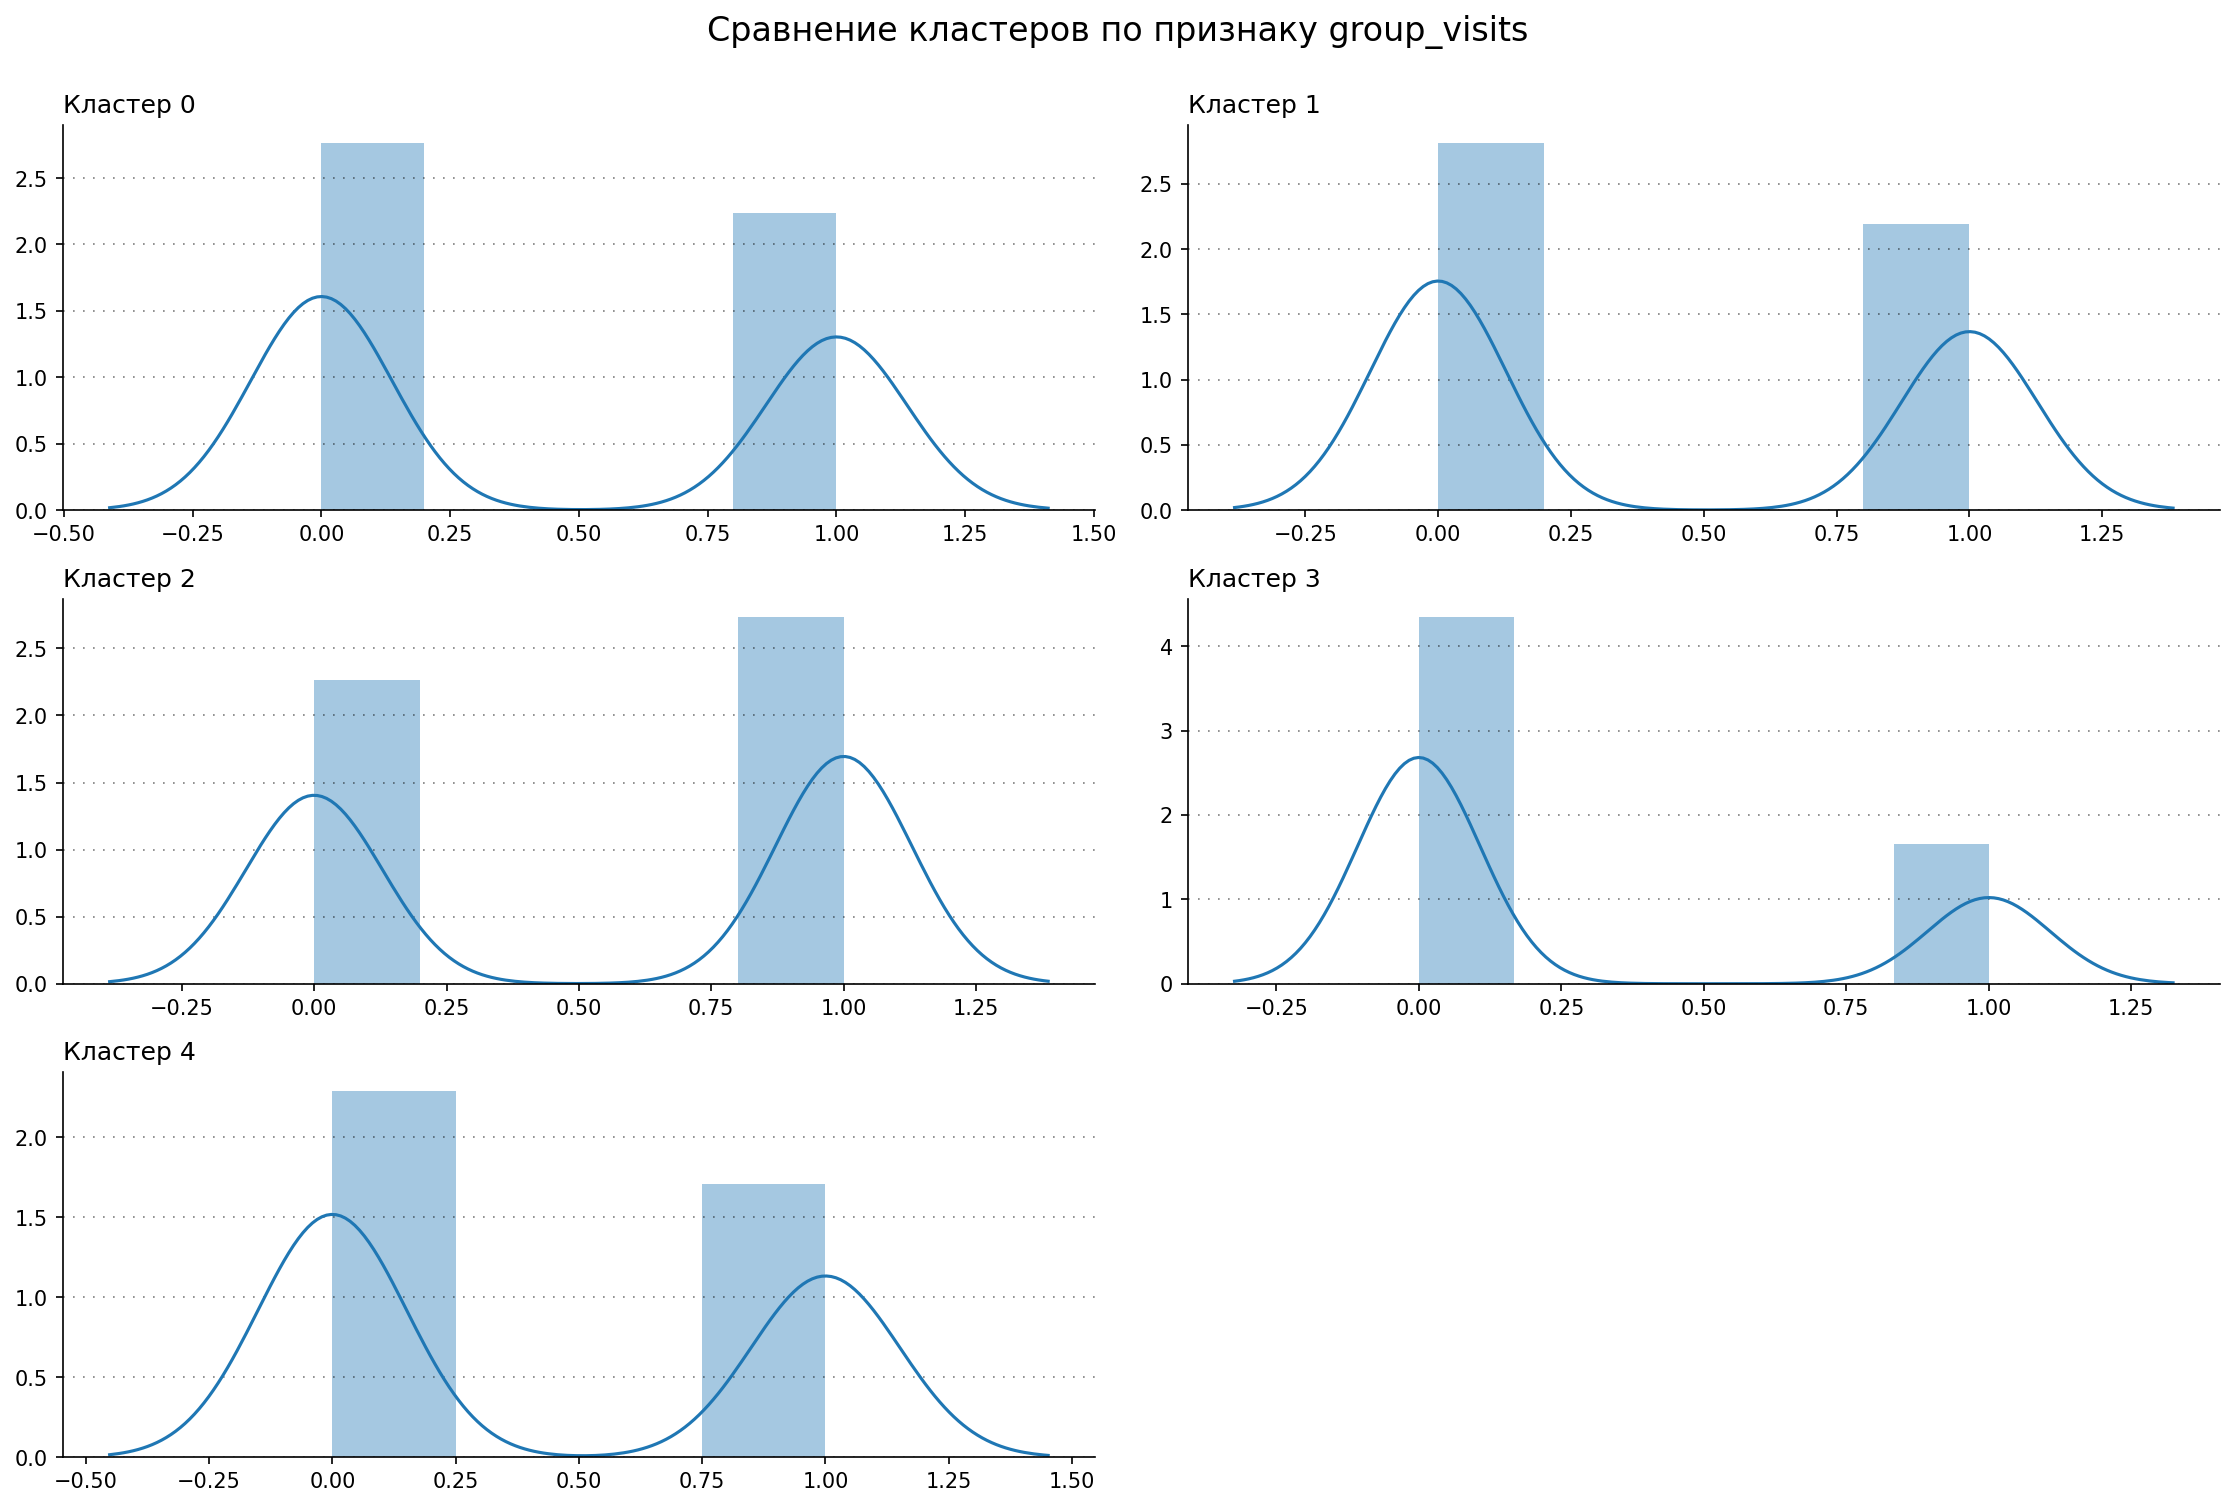

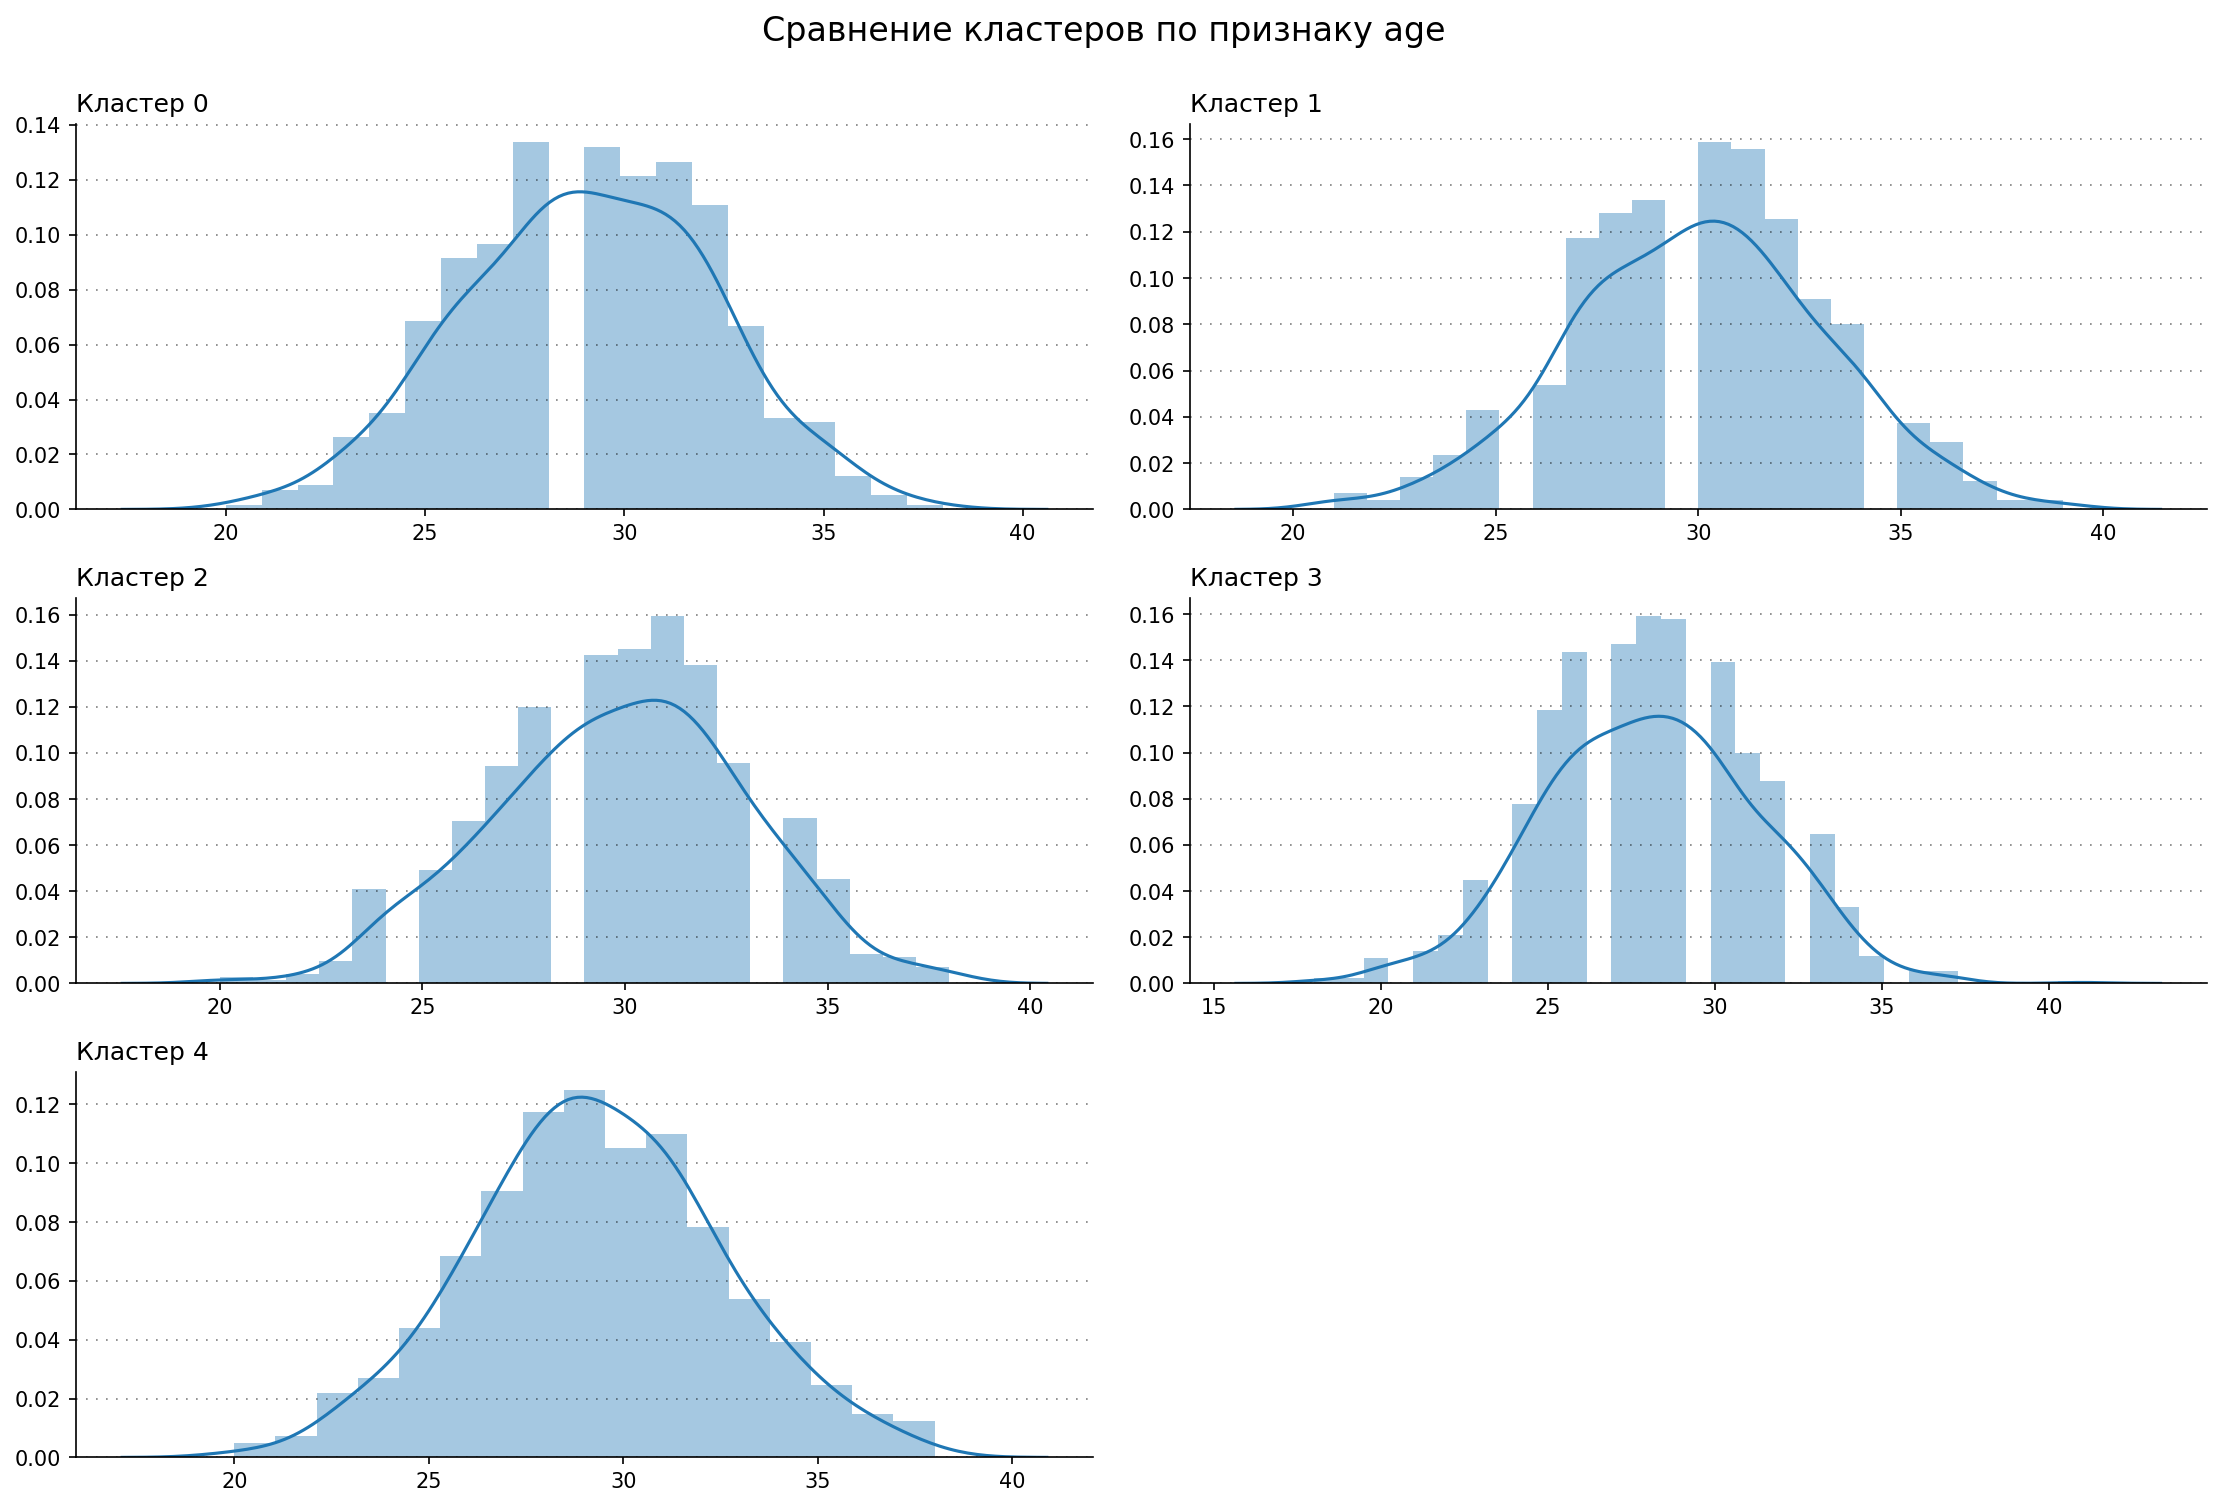

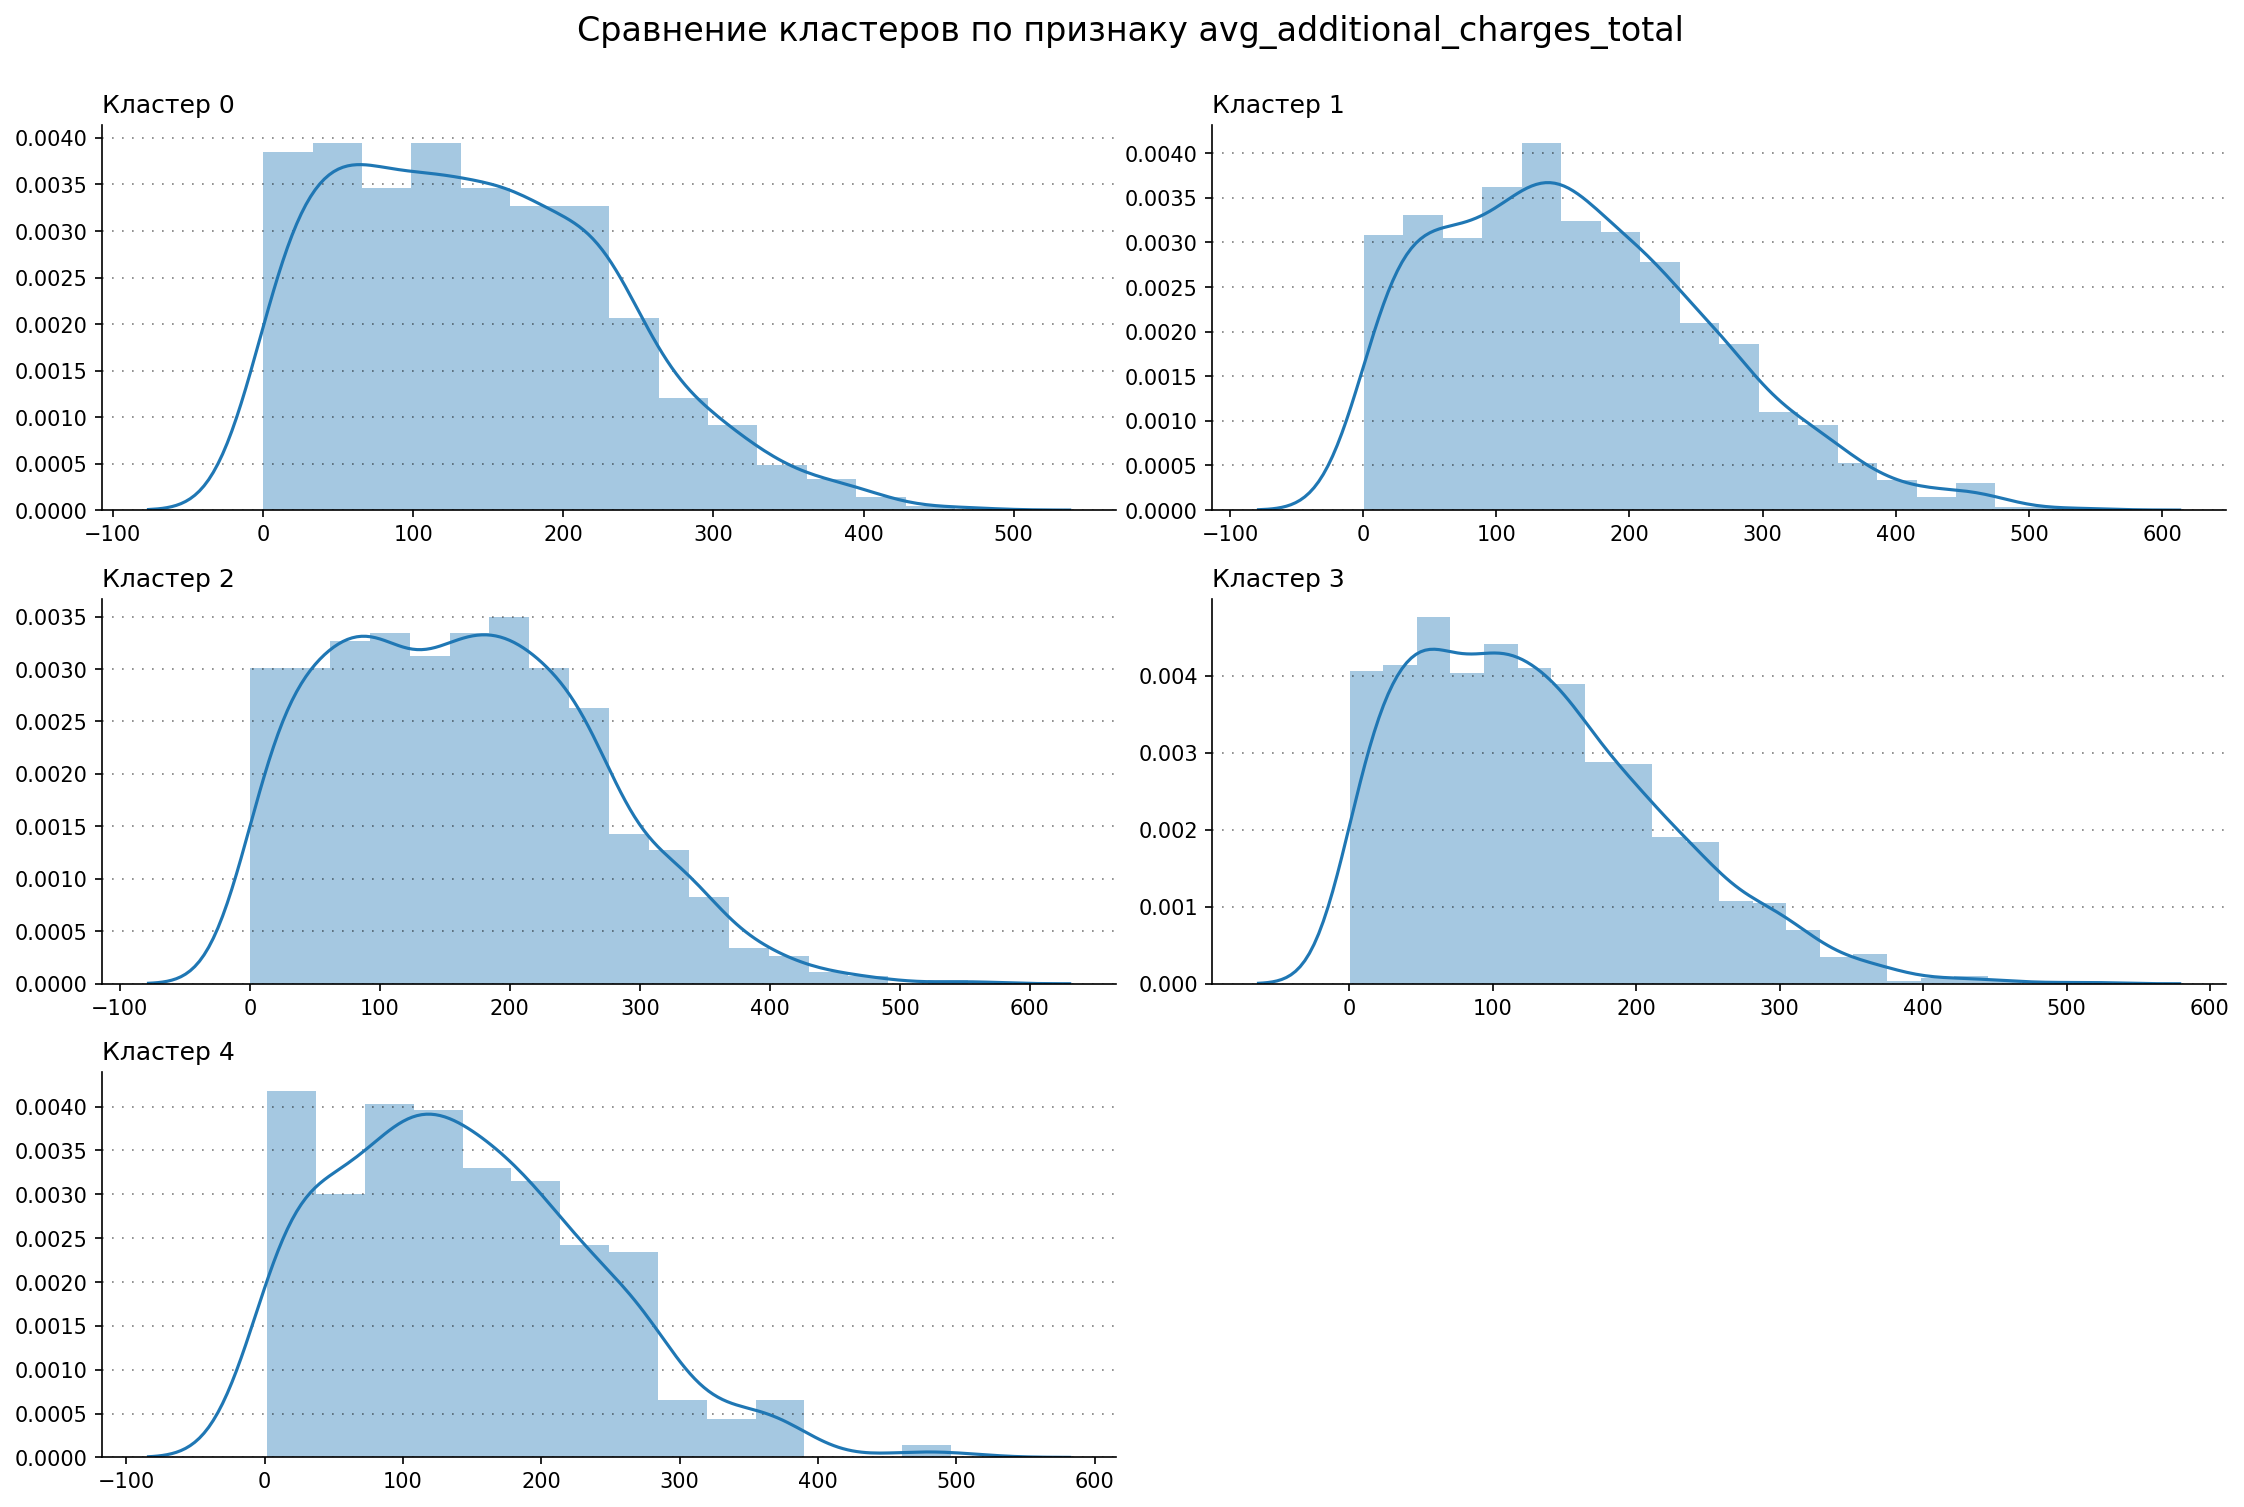

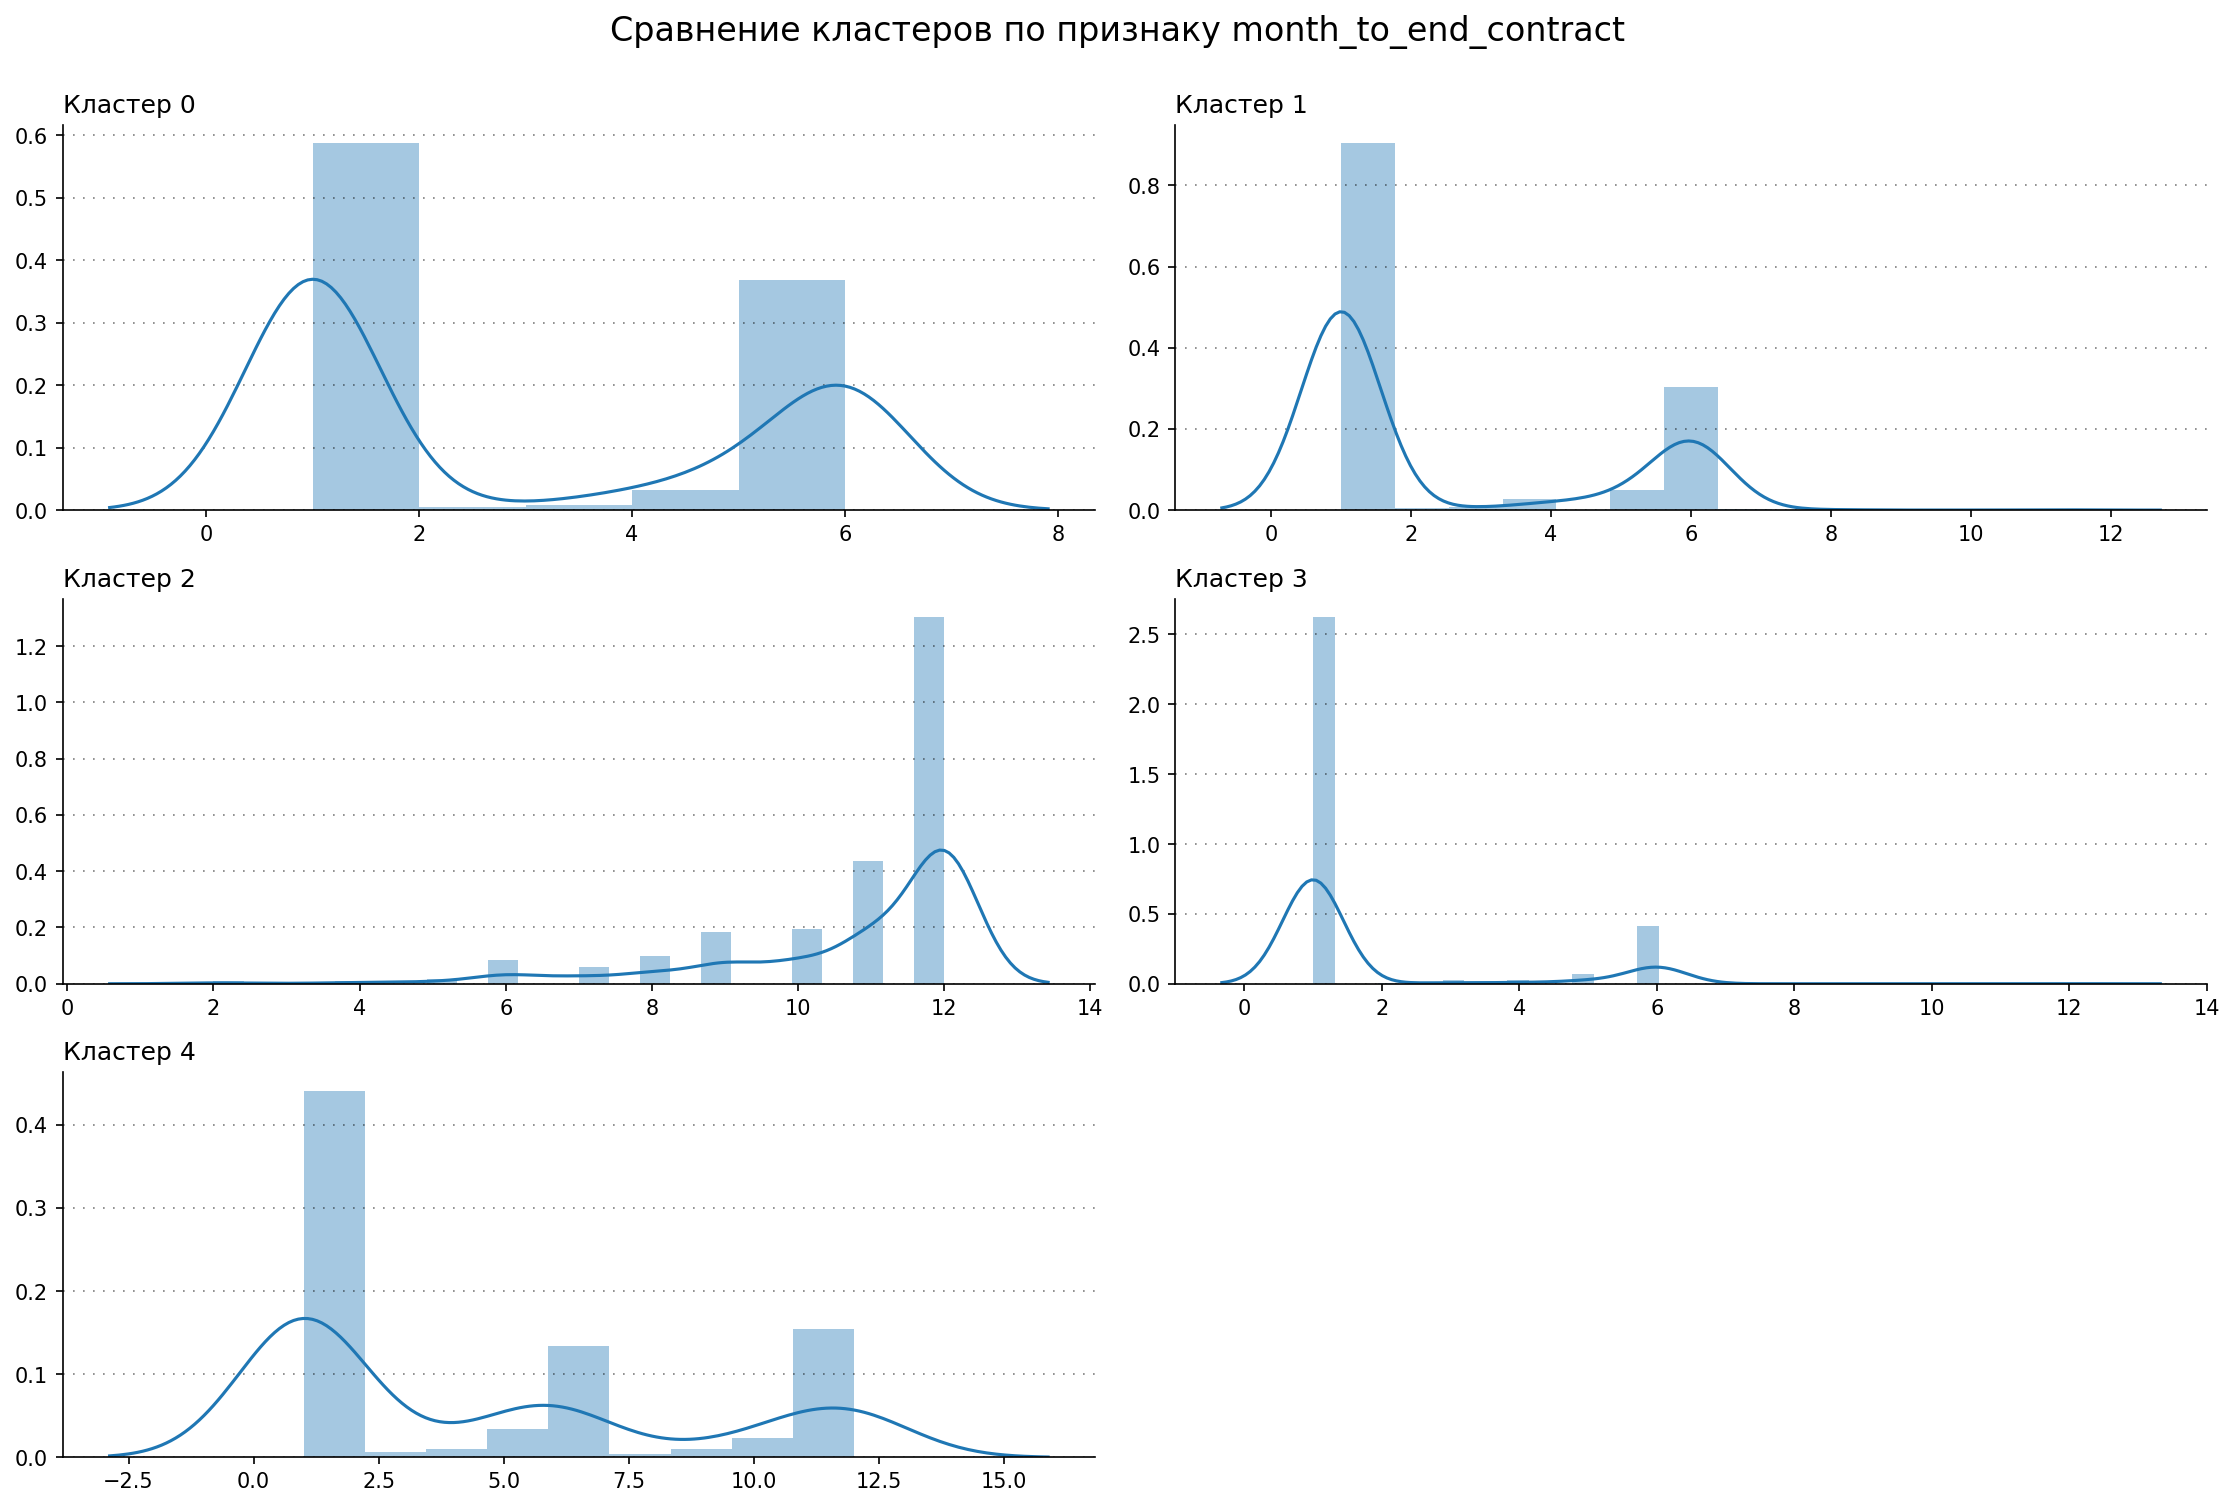

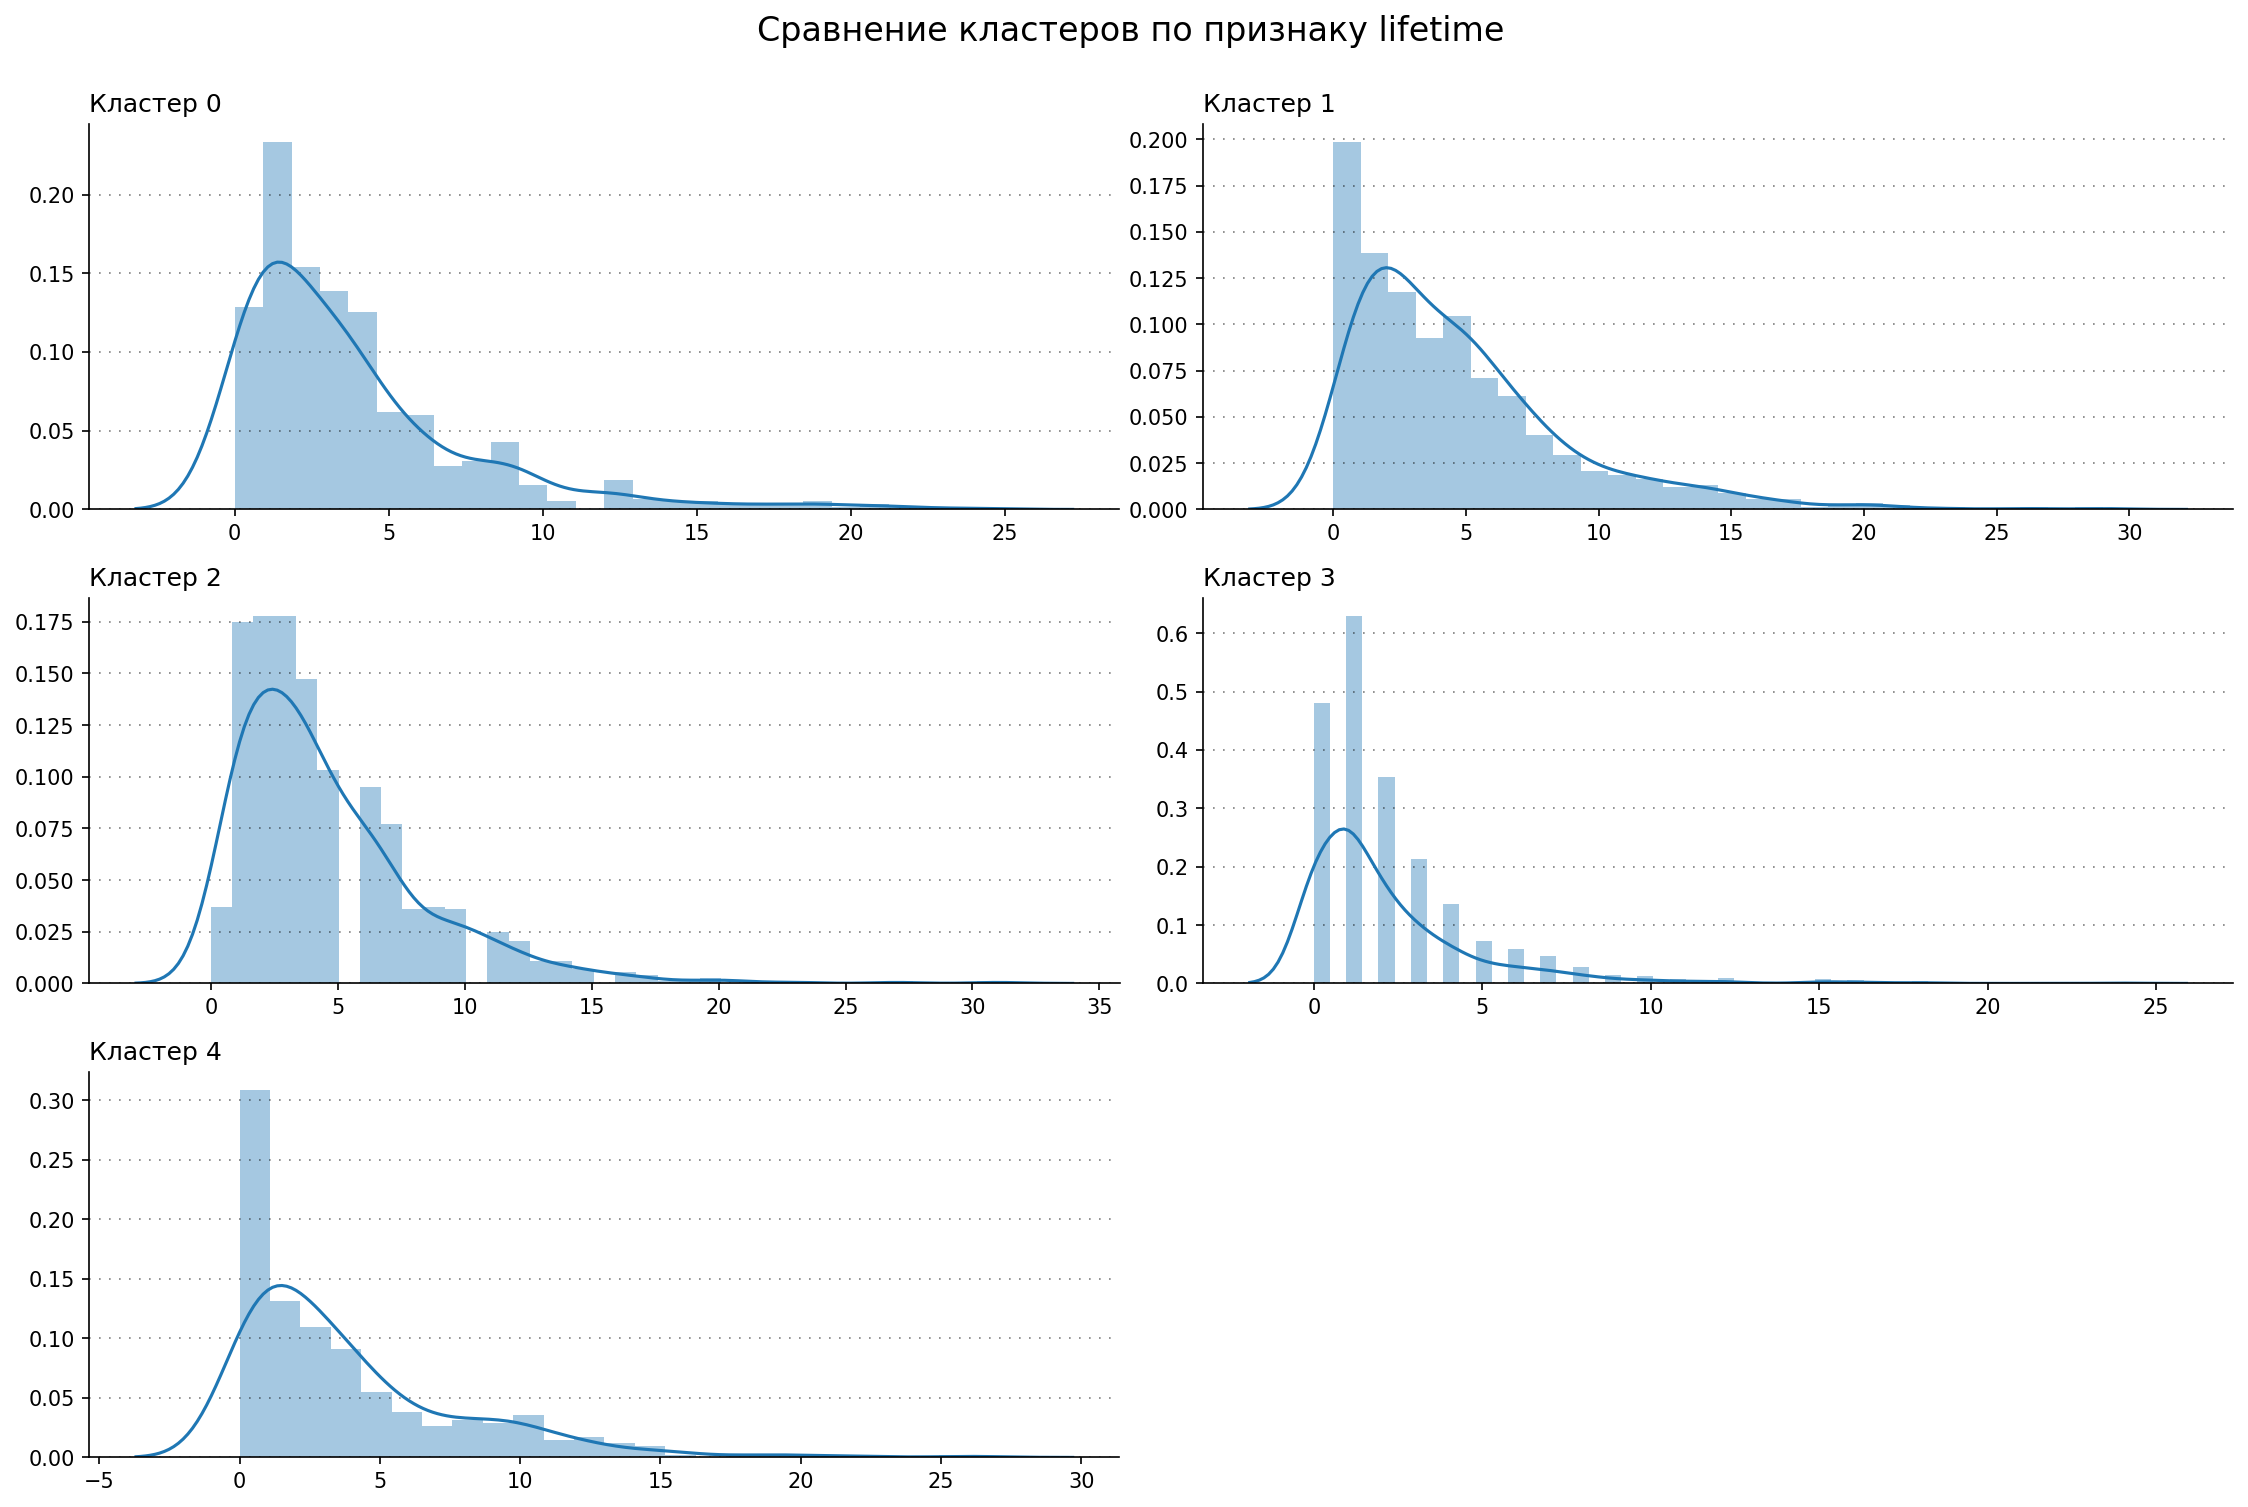

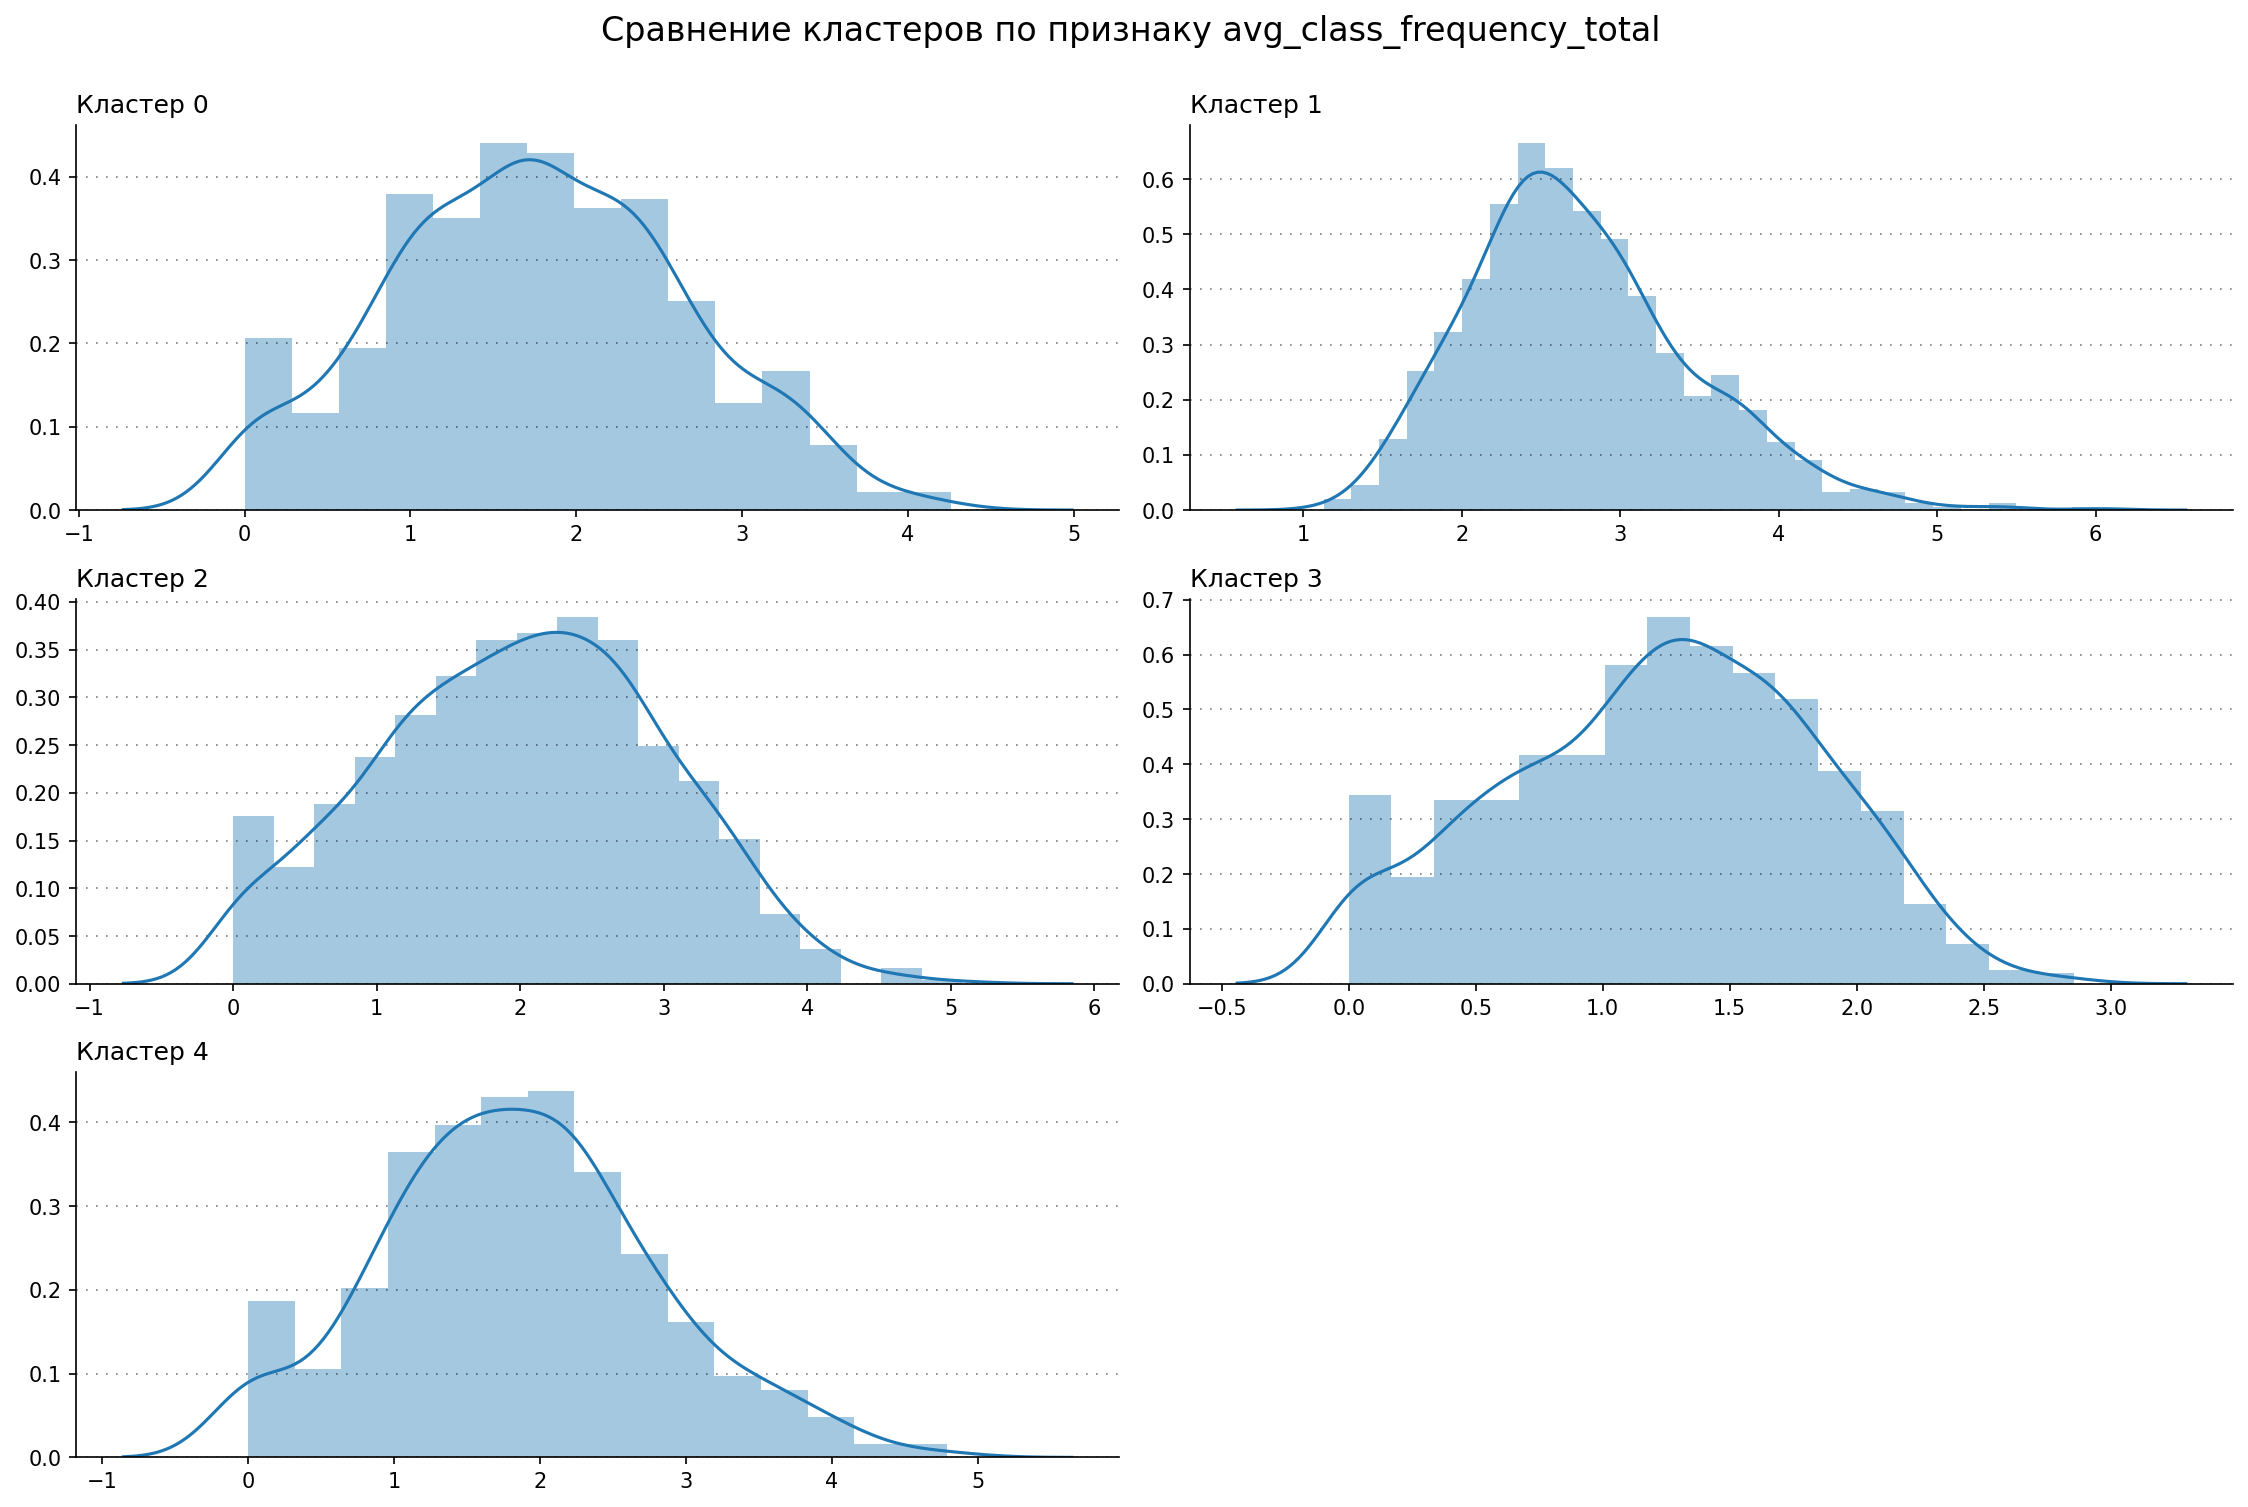

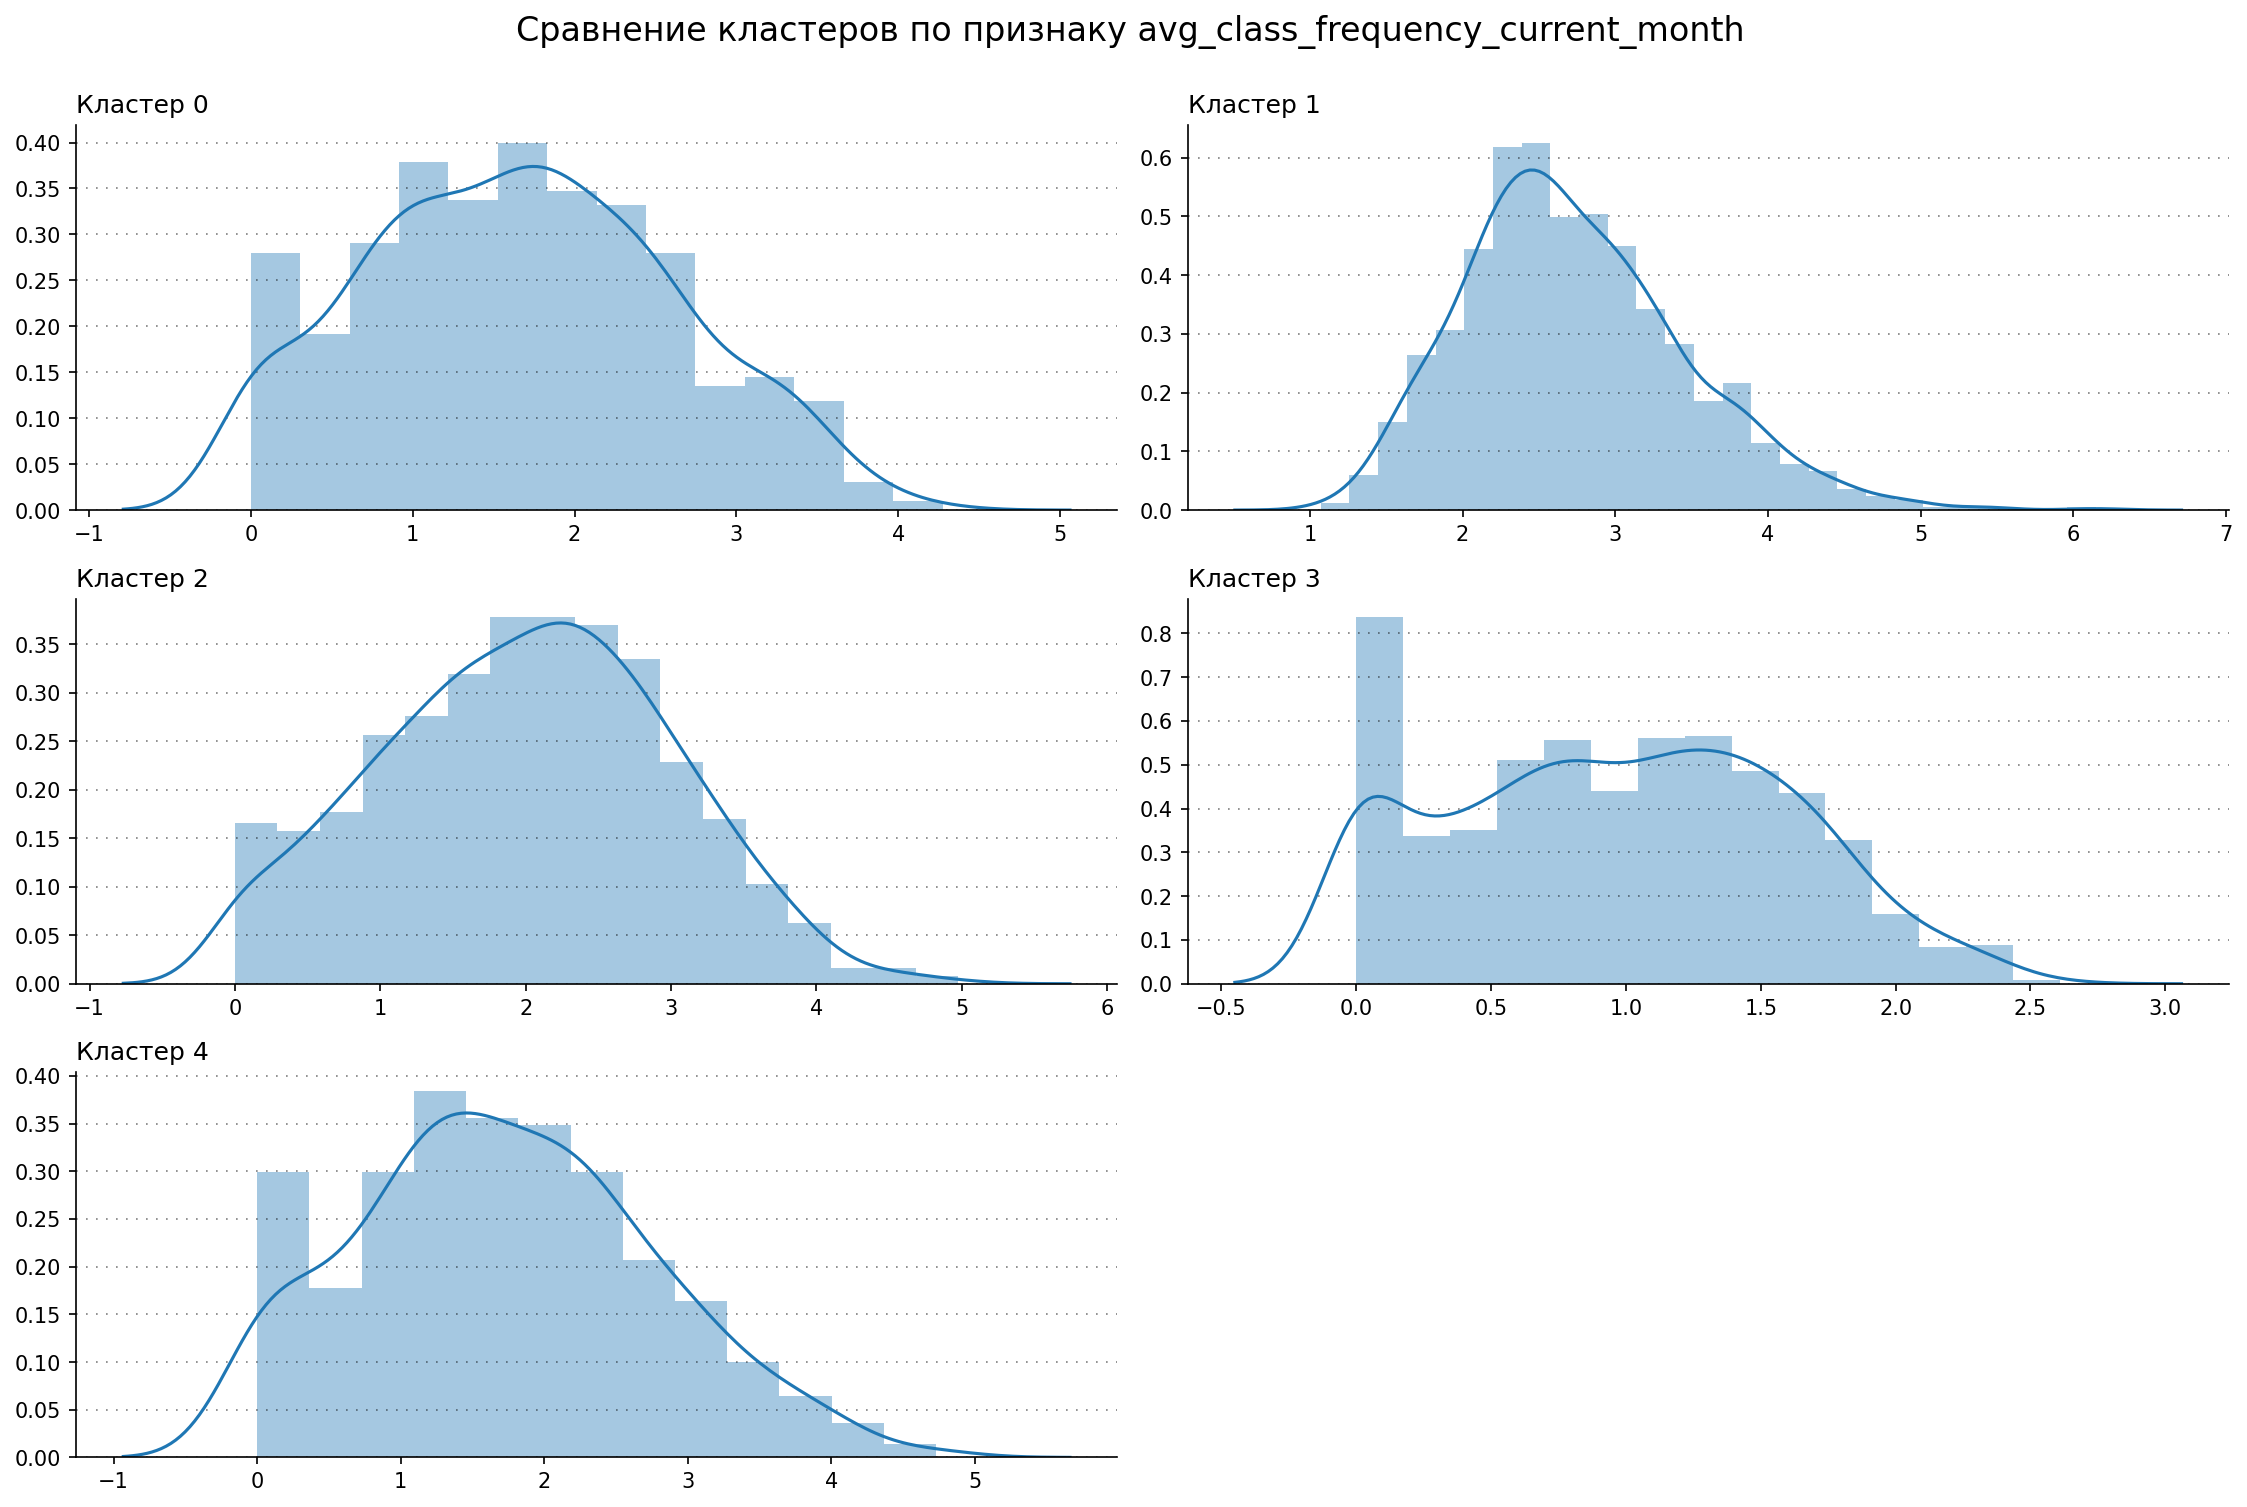

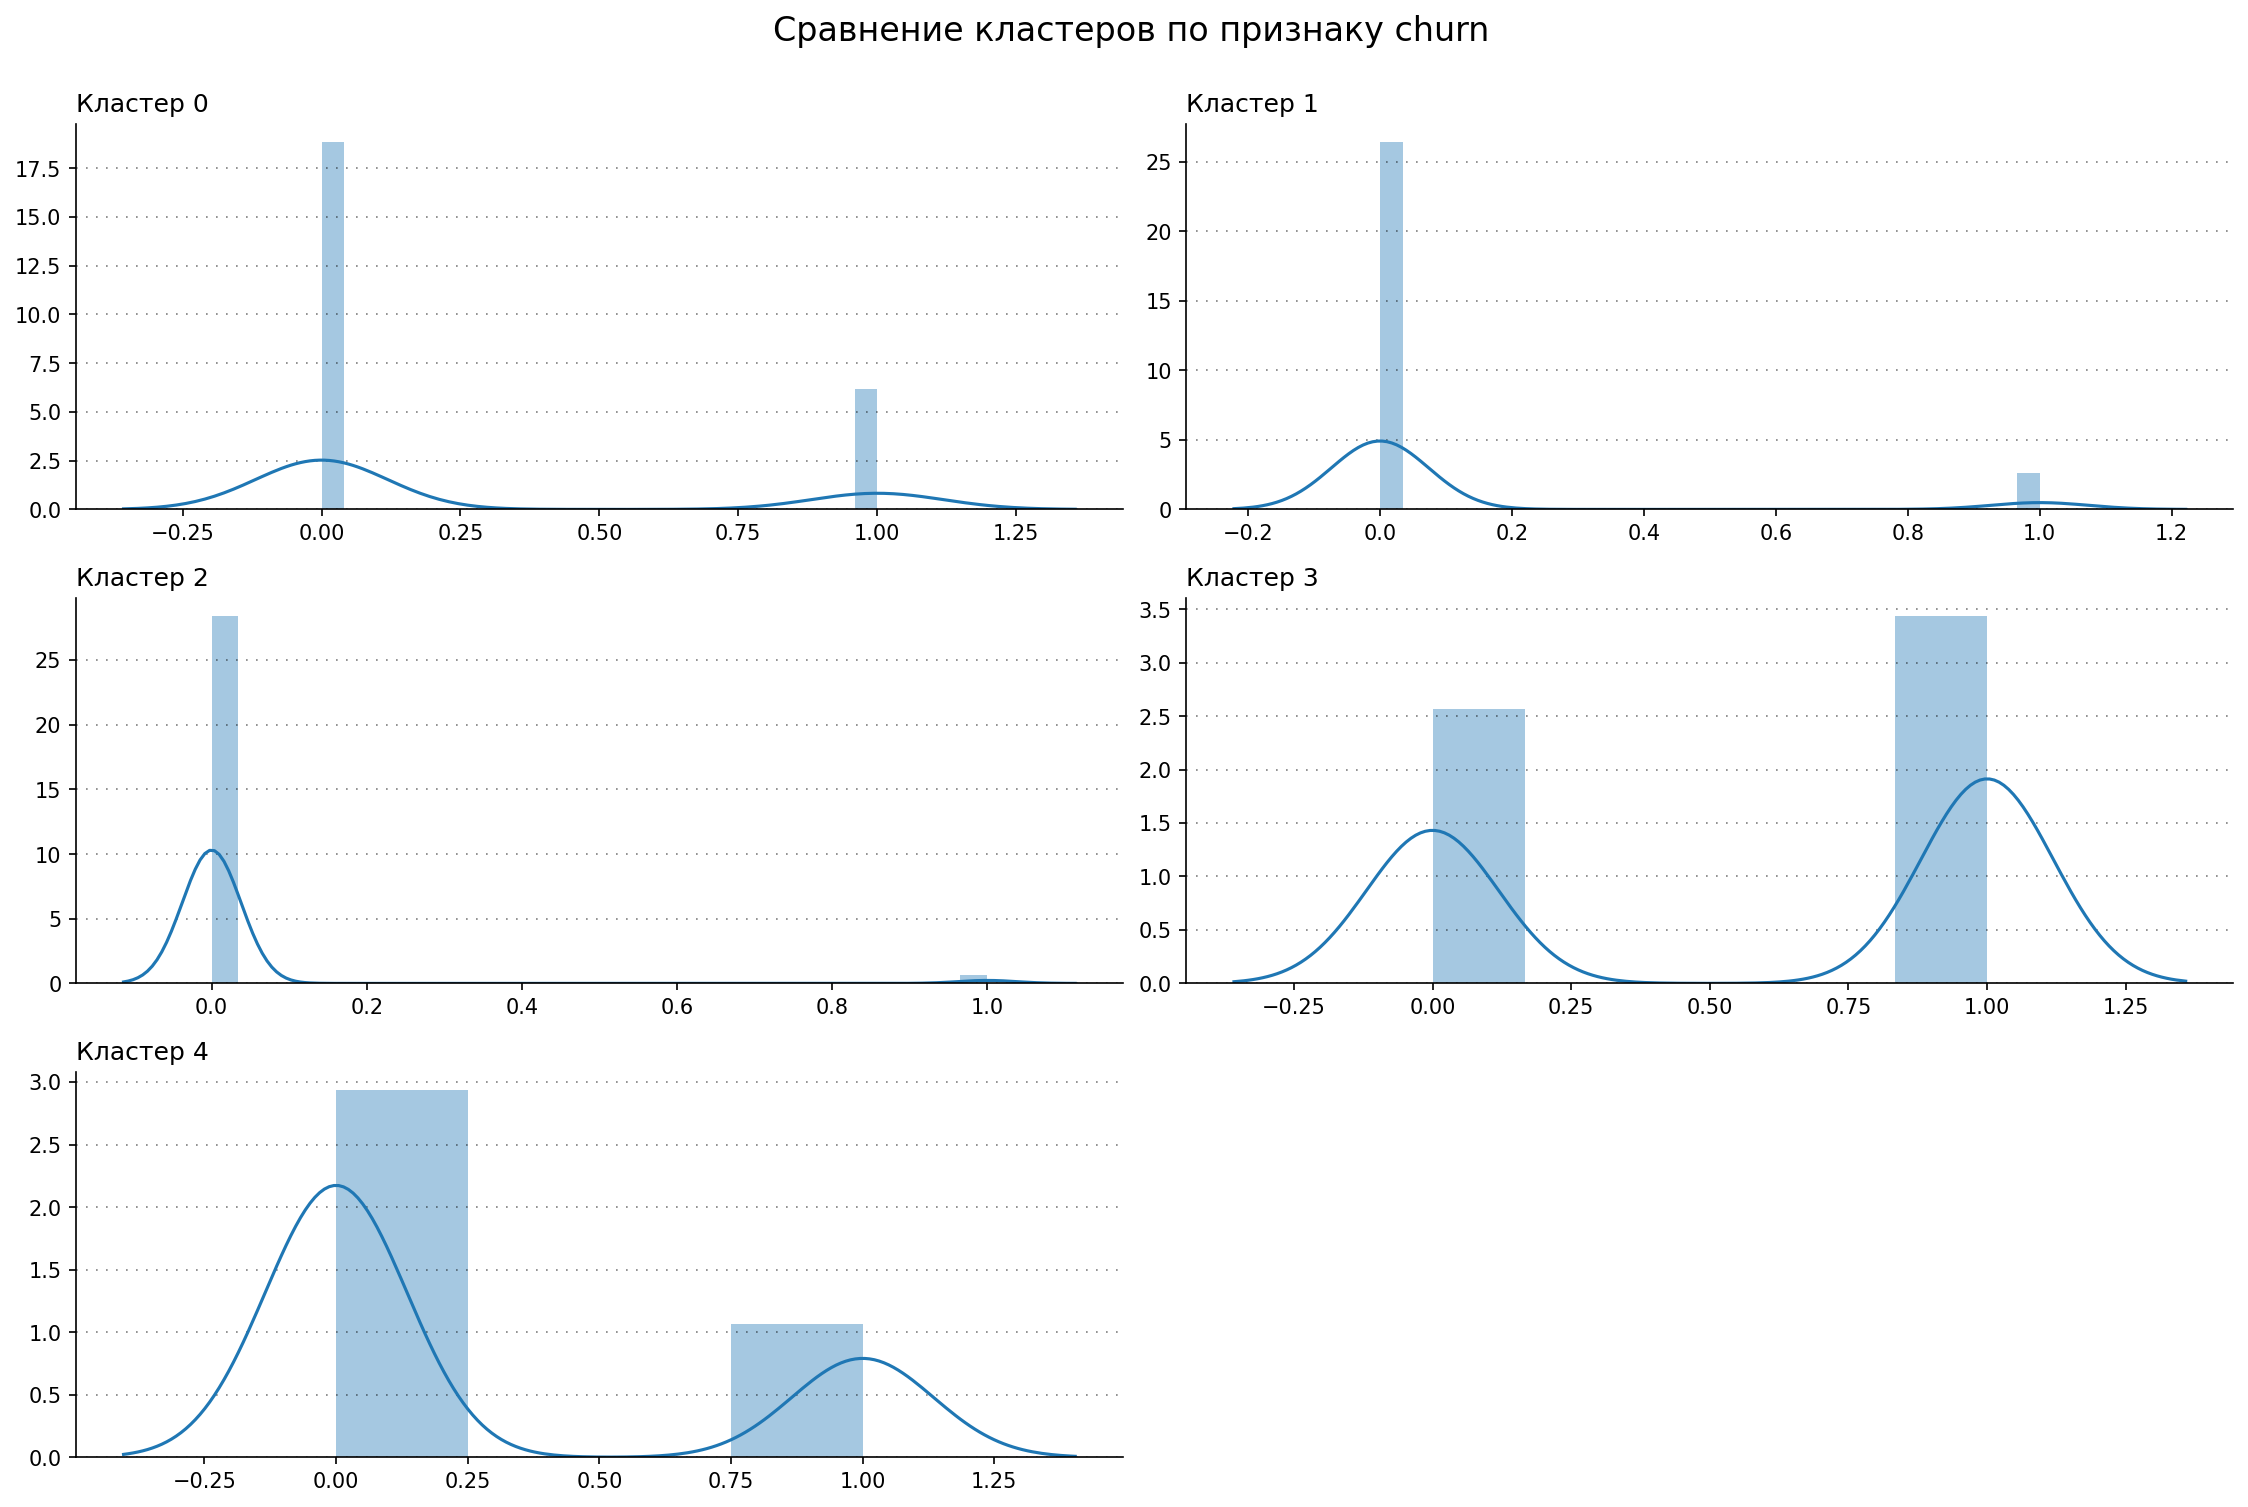

In [41]:
for feature in gym_churn.drop('clusters_km', axis=1).columns:
    cluster_features(feature)

Помимо описанных выше наблюдений, интересным является последняя диаграмма, где кластеры сравниваются по оттоку. В кластерах 1, 2 и 3 практически нет ушедших пользователей. В остальных они распределены практически поровну. Рассмотрю отток повнимательей в разбивке по кластерам

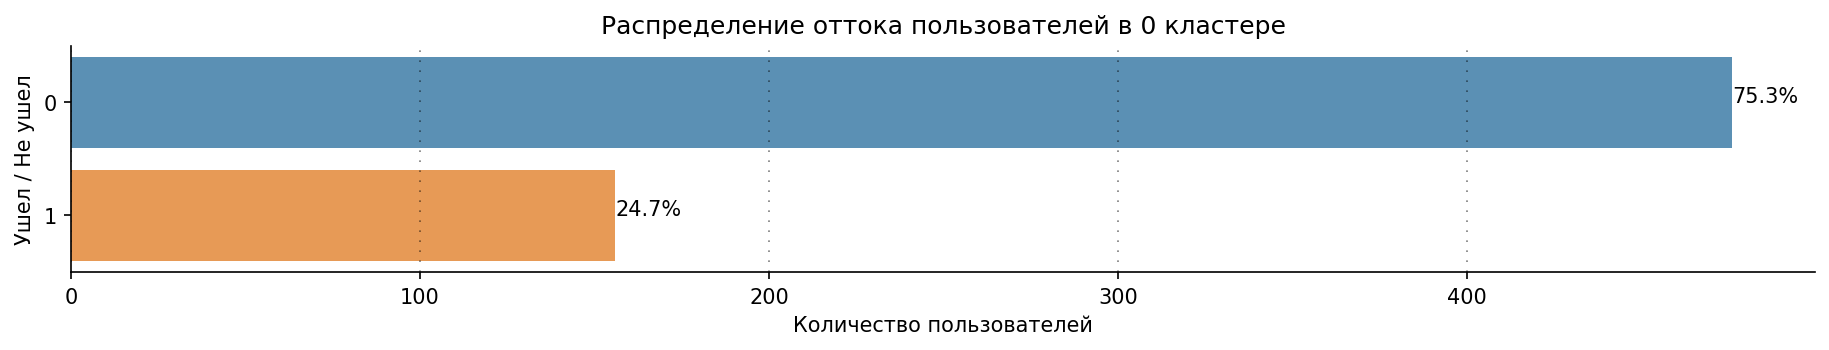

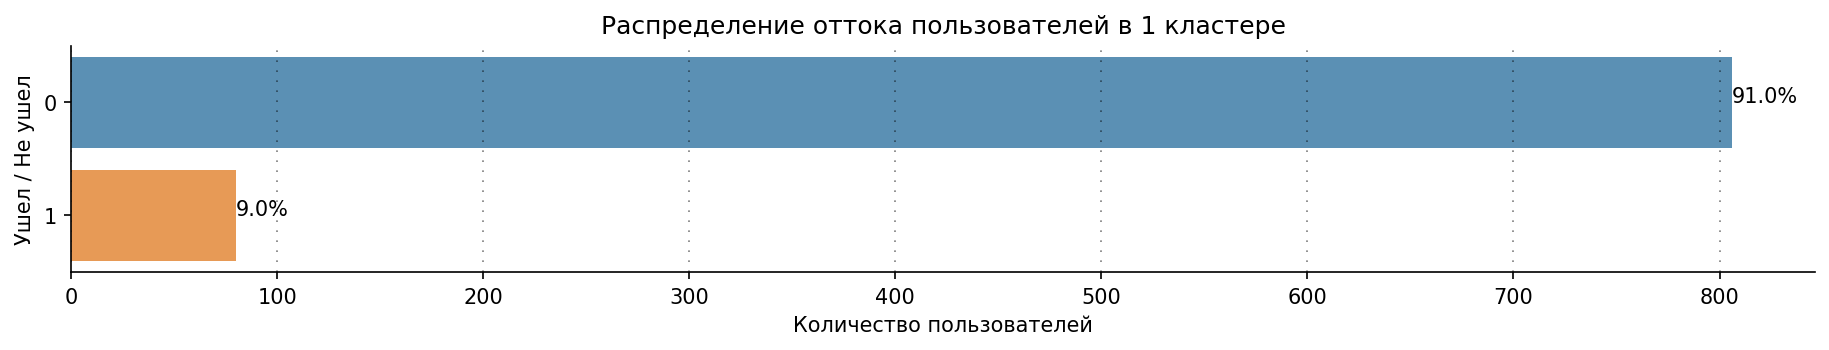

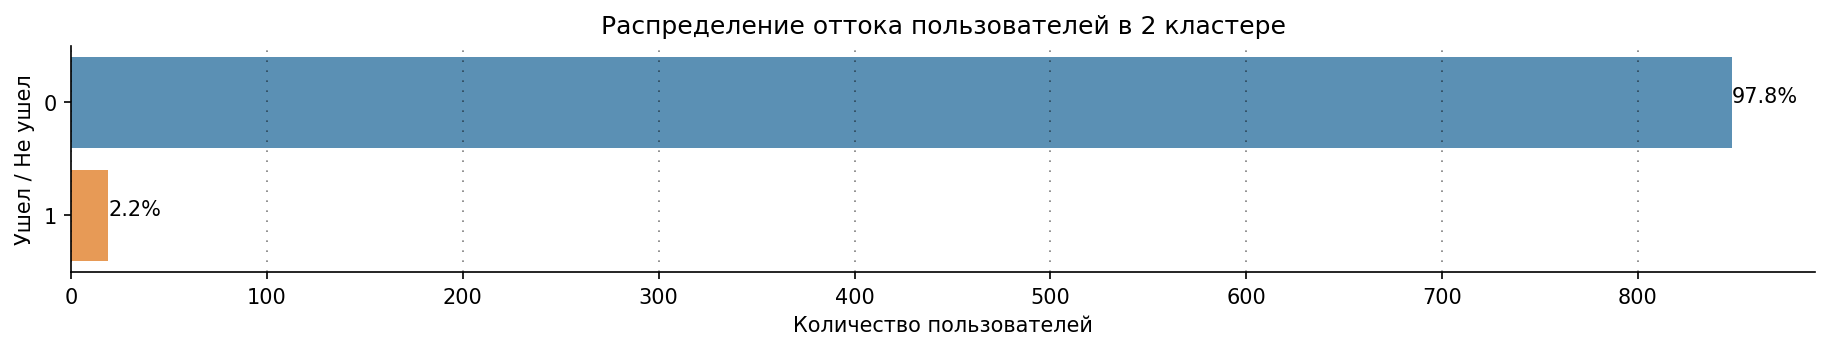

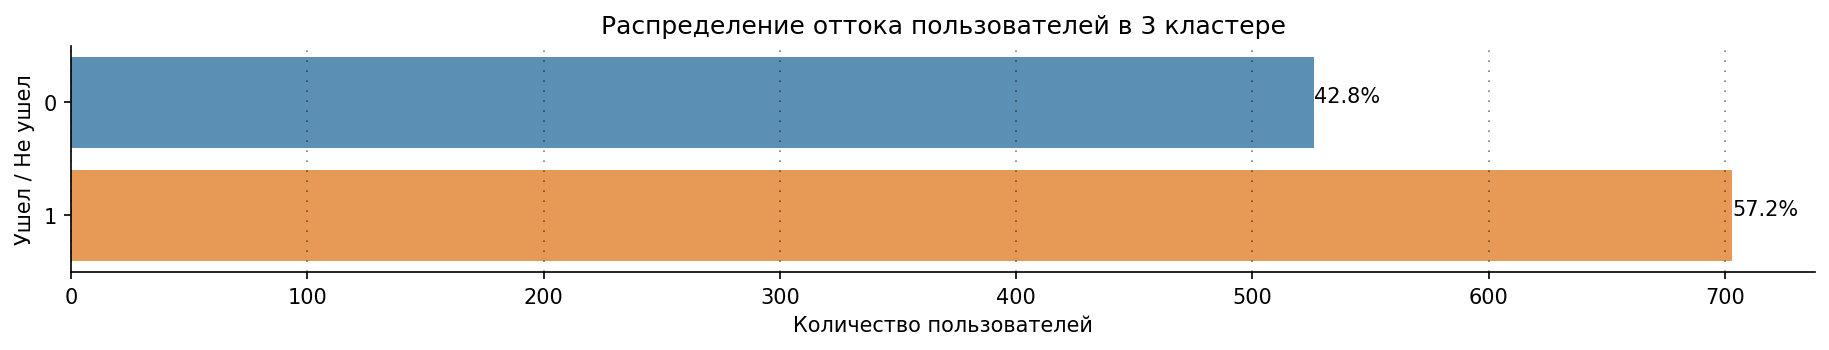

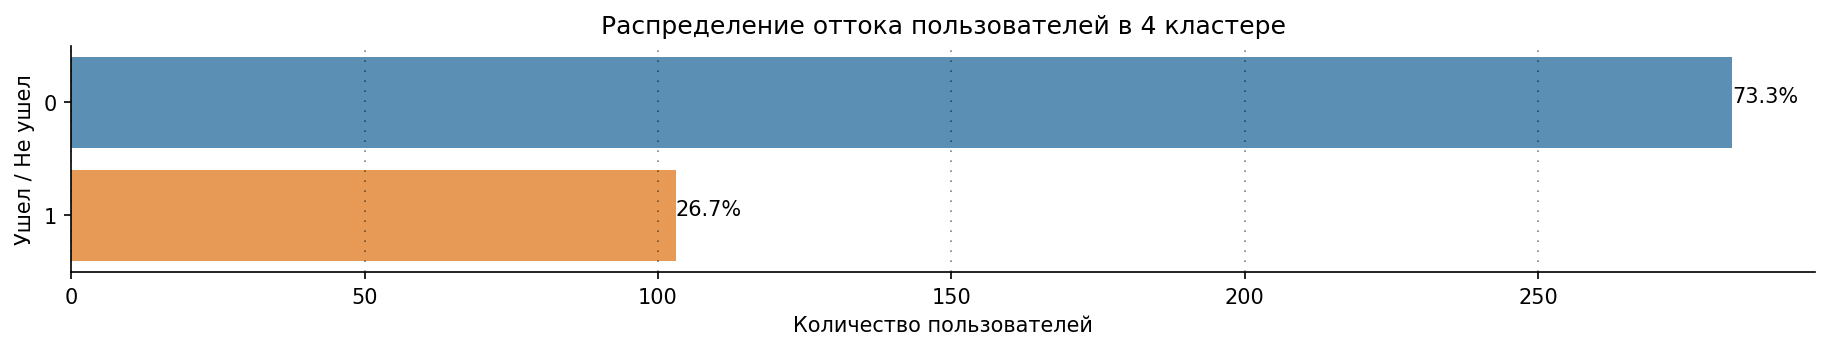

In [42]:
for i in range(5):
    fig = plt.figure(figsize=(15, 2), dpi=150)
    ax = sns.countplot(y='churn', data=gym_churn[gym_churn['clusters_km'] == i], alpha=0.8)
    total = gym_churn[gym_churn['clusters_km'] == i].shape[0]
    ax.grid(b=True, color='black', linestyle=':', axis='x', dashes=(1,5), alpha=0.5)
    ax.set_title('Распределение оттока пользователей в {} кластере'.format(i))

    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width() / total)
        x = p.get_x() + p.get_width()
        y = p.get_y() + p.get_height() / 2
        ax.annotate(percentage, (x, y))

    ax.set_xlabel('Количество пользователей')
    ax.set_ylabel('Ушел / Не ушел')
    sns.despine()
    plt.show()

В Кластере 0 практически такое же распределение как и в основном датасете. В Кластере 1 меньше всего ушедших пользователей. Во Кластере 2 также очень мало ушедших. В Кластерах 3 и 4 практически поровну.

### 8. Выводы и рекомендации <a id='conclusions'> </a>

После проведенного исследования можно вывести несколько важных признаков, которые могут свидетельствовать о том, что пользователь покинет фитнес в ближайшем месяце:

**Время жизни**

Согласно модели машинного обучения, является важнейшим признаком. Можно найти этому логическое объяснение. Клиент-"долгожитель" скорей всего всем итак доволен и уходить вряд ли собирается. А вот новые пользователи еще присматриваются и думат все ли их устраивает. Возможно стоит в первые пару месяцев их всячески "ублажать" давать скидки на дополнительные услуги или на следующий абонемент

**Частота посещения в последний месяц**

Тоже логично и объяснимо. Пользователя не все устраивает и он с меньшей охотой посещает зал. Может это связано с тем, что у него не все получается. Возможно, стоит рассмотреть необходимость выделения инструктора новым пользователям, чтобы они помогли освоиться и тем самым сподвигли его остаться.

**Возраст и период абонемента**

Молодые люди легче меняют свое окружение. Чем человек взрослее тем он с большей неохотой идет на перемены.  
  
Что касается контракта, то пользователи которые заключают непродолжительный контракт, должны быть под пристальным вниманием. Модель машинного обучения показала, что такие пользователи чаще уходят